# Analisis Exploratorio de Datos de PE La Castellana

In [1]:
import sys 
print(sys.version)

3.11.8 | packaged by Anaconda, Inc. | (main, Feb 26 2024, 21:34:05) [MSC v.1916 64 bit (AMD64)]


In [2]:
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
#import requests

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import mean_squared_error, r2_score

from dateutil.parser import parse 

import warnings
warnings.filterwarnings('ignore')

plt.rcParams.update({'figure.figsize': (21,7), 'figure.dpi':120})
%matplotlib inline

## meteostat
from datetime import datetime, timedelta
from meteostat import Hourly
from meteostat import Point, Daily
from meteostat import Stations


##mis funciones
#from datetime import timedelta #si no se define dentro de la funcion arroja error
from clean_data import remover_valores_repetidos
from clean_data import rango_fechas_repe
from clean_data import rango_fechas_repe_exc
from clean_data import weighted_circular_mean

from smec_energy import calcular_energia_lcas,smec_data

El dataset que se va a trabajar corresponde al Parque Eólico La Castellana ubicado en Bahia Blanca, Buenos Aires, Argentina.

In [3]:
#path = 'https://raw.githubusercontent.com/guilledesimone/MMA/main/Datos_LAC_SOTR_2019_2024_horario.csv'
path = 'D:\\Documents\\MMA\\1.0 Tesis\\Datos\\Datos_LAC_SOTR_2019_2024_horario.csv'


data_types = {          
    'TotPwrWTGs': float        
    ,'Nro_Available_WTGs': float
    ,'VelViento': float
    ,'VelVientoWTGS': float
    ,'DirVientoPond': float
    ,'Temp': float
    ,'HumedadRel': float
    ,'PresionAtm': float
    ,'ENERGIA_SMEC': float
    ,'ENERGIA_PRON_CAMMESA': float
    ,'ERROR_PRONOSTICO': float
}


df = pd.read_csv(path, dtype=data_types, decimal=',', parse_dates=['FechaHora'], 
                 date_format='%Y-%m-%d %H:%M:%S.%f', delimiter=';', header=0)


#da error al leer el csv para los campo que tienen el punto como separador de miles (converti el formato del a nuemero 
#para columnas PresionAtm y ERROR_PRONOSTICO), en el excel formatear estas columnas en personalizado standard

#### Descripción del dataset
Este dataset corresponde a los datos producción de generación de energia y los meteorológicos del parque eólico La Castellana ubicado en Bahia Blanca provincia de Buenos Aires, Argentina. El parque tiene una potencia instalada de 100 Mw.

El dataset cuenta con datos desde Enero del 2019 a la actualidad.  


#### Descripción de las variables del dataset
* TotPwrWTGs: Es la suma de la energia horaria generada por cada turbina del parque. Fuente sistema Scada del parque        
* Nro_Available_WTGs: Es un contador de turbinas que estan en un estado de indisponibilidad, se infiere este estado por estar consumiendo energia auxiliar (valores de potencia en 0 o negativos)
* VelViento: Velocidad del viento promedio horario, a baja altura. Fuente Estación meteorologica del parque.
* VelVientoWTGS: Velocidad del viento promedio horario, a la altura del Nassel del aero generador 126mts. Fuente Estación meteorologica del parque.
* DirVientoPond: Dirección del viento horaria promedio ponderado con la velocidad del viento.   
* Temp: Temperatura ambiente promedio horario. Fuente Estación meteorologica del parque.
* HumedadRel: Humedad promedio horaria. Fuente Estación meteorologica del parque.
* PresionAtm: Presion atmosféria horaria. Fuente Estación meteorologica del parque.   
* ENERGIA_SMEC: Es la energia horaria neta producida medida por el medidor de energia del parque. Es por la que remunera Cammesa o el cliente. Es un poco menor que la TotPwrWTGs por que resta la energia auxiliar consumida por la propia planta para producir.   
* ENERGIA_PRON_CAMMESA: Es la energia pronosticada por Cammesa que se va a producir en la planta. 
* ERROR_PRONOSTICO: Es el error del pronostico, diferencia entre ENERGIA_SMEC y ENERGIA_PRON_CAMMESA

Estas últimas 3 variables provienen de la base de datos de Cammesa y la ENERGIA_SMEC esta garantizado que es un dato de calidad por que se interroga directamente desde el medidor de energia y se utiliza para facturar.

In [4]:
#cambio nombre de las columnas
nom_colum = ['FechaHora','EnergiaTGW','AerosDisp','VelViento','VelVientoWTGS','DirViento','TempAmb','HumedadRel','PresionAtm','EnergiaSMEC','PronosticoCammesa','ErrorPronostico']

df.columns = nom_colum

df.tail()

,FechaHora,EnergiaTGW,AerosDisp,VelViento,VelVientoWTGS,DirViento,TempAmb,HumedadRel,PresionAtm,EnergiaSMEC,PronosticoCammesa,ErrorPronostico
46309,2024-04-13 14:00:00,22.44,30.00,0.25,6.13,118.42,14.07,87.38,1015.22,NaN,NaN,NaN
46310,2024-04-13 15:00:00,31.49,30.00,0.25,6.70,121.72,14.32,85.98,1014.76,NaN,NaN,NaN
46311,2024-04-13 16:00:00,30.67,29.33,0.25,6.67,122.90,14.56,83.85,1014.34,NaN,NaN,NaN
46312,2024-04-13 17:00:00,37.31,29.00,0.25,7.12,113.95,14.76,82.30,1013.74,NaN,NaN,NaN
46313,2024-04-13 18:00:00,18.28,19.17,0.25,6.49,91.85,14.43,82.55,1013.39,NaN,NaN,NaN


#### Limpieza de datos

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 46314 entries, 0 to 46313
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   FechaHora          46314 non-null  datetime64[ns]
 1   EnergiaTGW         43459 non-null  float64       
 2   AerosDisp          43485 non-null  float64       
 3   VelViento          43459 non-null  float64       
 4   VelVientoWTGS      43461 non-null  float64       
 5   DirViento          43459 non-null  float64       
 6   TempAmb            43459 non-null  float64       
 7   HumedadRel         43459 non-null  float64       
 8   PresionAtm         43459 non-null  float64       
 9   EnergiaSMEC        46272 non-null  float64       
 10  PronosticoCammesa  33408 non-null  float64       
 11  ErrorPronostico    33408 non-null  float64       
dtypes: datetime64[ns](1), float64(11)
memory usage: 4.2 MB


#### Extracción de datos de energia desde API de Energia_SMEC para completar datos hasta la actualidad

In [6]:
# Filtro los registros con EnergiaSMEC igual a NaN, para obtener fecha minima
f_desde =  df[df['EnergiaSMEC'].isna()]['FechaHora'].min().date()
f_hasta = datetime.now().date()

print("Min FechaHora for EnergiaSMEC NaN:", f_desde)
print("Max FechaHora for EnergiaSMEC NaN:", f_hasta)

result_df = calcular_energia_lcas(f_desde,f_hasta).iloc[:-1]
result_df.tail()

Min FechaHora for EnergiaSMEC NaN: 2024-04-12
Max FechaHora for EnergiaSMEC NaN: 2024-04-17


,FechaHora,LCASM61P,LCASM62P,LCA2M61P,EnergiaSMEC
122,2024-04-17 03:00:00,33217,32857,3716,62.36
123,2024-04-17 04:00:00,22270,36014,3580,54.70
124,2024-04-17 05:00:00,24703,32523,3482,53.74
125,2024-04-17 06:00:00,28235,27291,3652,51.87
126,2024-04-17 07:00:00,30535,32616,3695,59.46


Completa el dataset con los datos de EnergiaSMEC desde el ultimo disponible hasta la fechahora de hoy

In [7]:
# Set 'FechaHora' as index for both DataFrames
#df_clean.set_index('FechaHora', inplace=True)
df.set_index('FechaHora', inplace=True)
result_df.set_index('FechaHora', inplace=True)

# Concatenate df_clean and result_df
df = pd.concat([df, result_df['EnergiaSMEC']])

# Remove duplicate rows based on 'FechaHora' index
df = df[~df.index.duplicated(keep='first')]

# Update values in df_clean['EnergiaSMEC'] with values from result_df['EnergiaSMEC']
df.update(result_df['EnergiaSMEC'], overwrite=False)

# Reset index to make 'FechaHora' a column again
df.reset_index(inplace=True)


In [8]:
# Display the tail of the merged DataFrame
df.tail(5)

,FechaHora,EnergiaTGW,AerosDisp,VelViento,VelVientoWTGS,DirViento,TempAmb,HumedadRel,PresionAtm,EnergiaSMEC,PronosticoCammesa,ErrorPronostico
46394,2024-04-17 03:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,62.36,NaN,NaN
46395,2024-04-17 04:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,54.70,NaN,NaN
46396,2024-04-17 05:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,53.74,NaN,NaN
46397,2024-04-17 06:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,51.87,NaN,NaN
46398,2024-04-17 07:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,59.46,NaN,NaN


#### Verficación de valores nulos

In [9]:
df.isnull().sum()

FechaHora                0
EnergiaTGW            2940
AerosDisp             2914
VelViento             2940
VelVientoWTGS         2938
DirViento             2940
TempAmb               2940
HumedadRel            2940
PresionAtm            2940
EnergiaSMEC              0
PronosticoCammesa    12991
ErrorPronostico      12991
dtype: int64

El valor a predecir es el de EnergiaSMEC, como se puede observar para las variables meteorológicas hay valores en null y ademas debo analizar la calidad de las variables meteorológicas para detectar inconsistencias. Esto implica que hubo un problema de comunicación con la estación meteorologica o con alguno de los sensores.  

In [10]:
df.dropna(subset=['EnergiaSMEC'], inplace=True)

#### Analisis de inconsistencias en variable meteorológicas

In [11]:
num_vars= nom_colum[2:10]
df[num_vars].describe().T

,count,mean,std,min,25%,50%,75%,max
AerosDisp,43485.0,26.590290,7.891548,0.00,25.670,29.83,31.000,32.00
VelViento,43459.0,6.964705,4.158332,0.00,3.940,6.74,10.020,23.78
VelVientoWTGS,43461.0,7.900356,3.238435,0.00,5.500,7.60,10.010,22.87
DirViento,43459.0,220.243480,105.141285,0.00,125.075,249.21,316.055,359.86
TempAmb,43459.0,13.393303,18.237190,-49.75,10.090,15.84,21.730,412.50
HumedadRel,43459.0,53.513666,50.521100,-55.52,29.780,47.38,67.820,394.40
PresionAtm,43459.0,971.298408,169.904135,0.00,999.720,1003.85,1008.030,1024.66
EnergiaSMEC,46399.0,47.652083,34.604288,-0.07,14.240,45.15,82.970,99.44


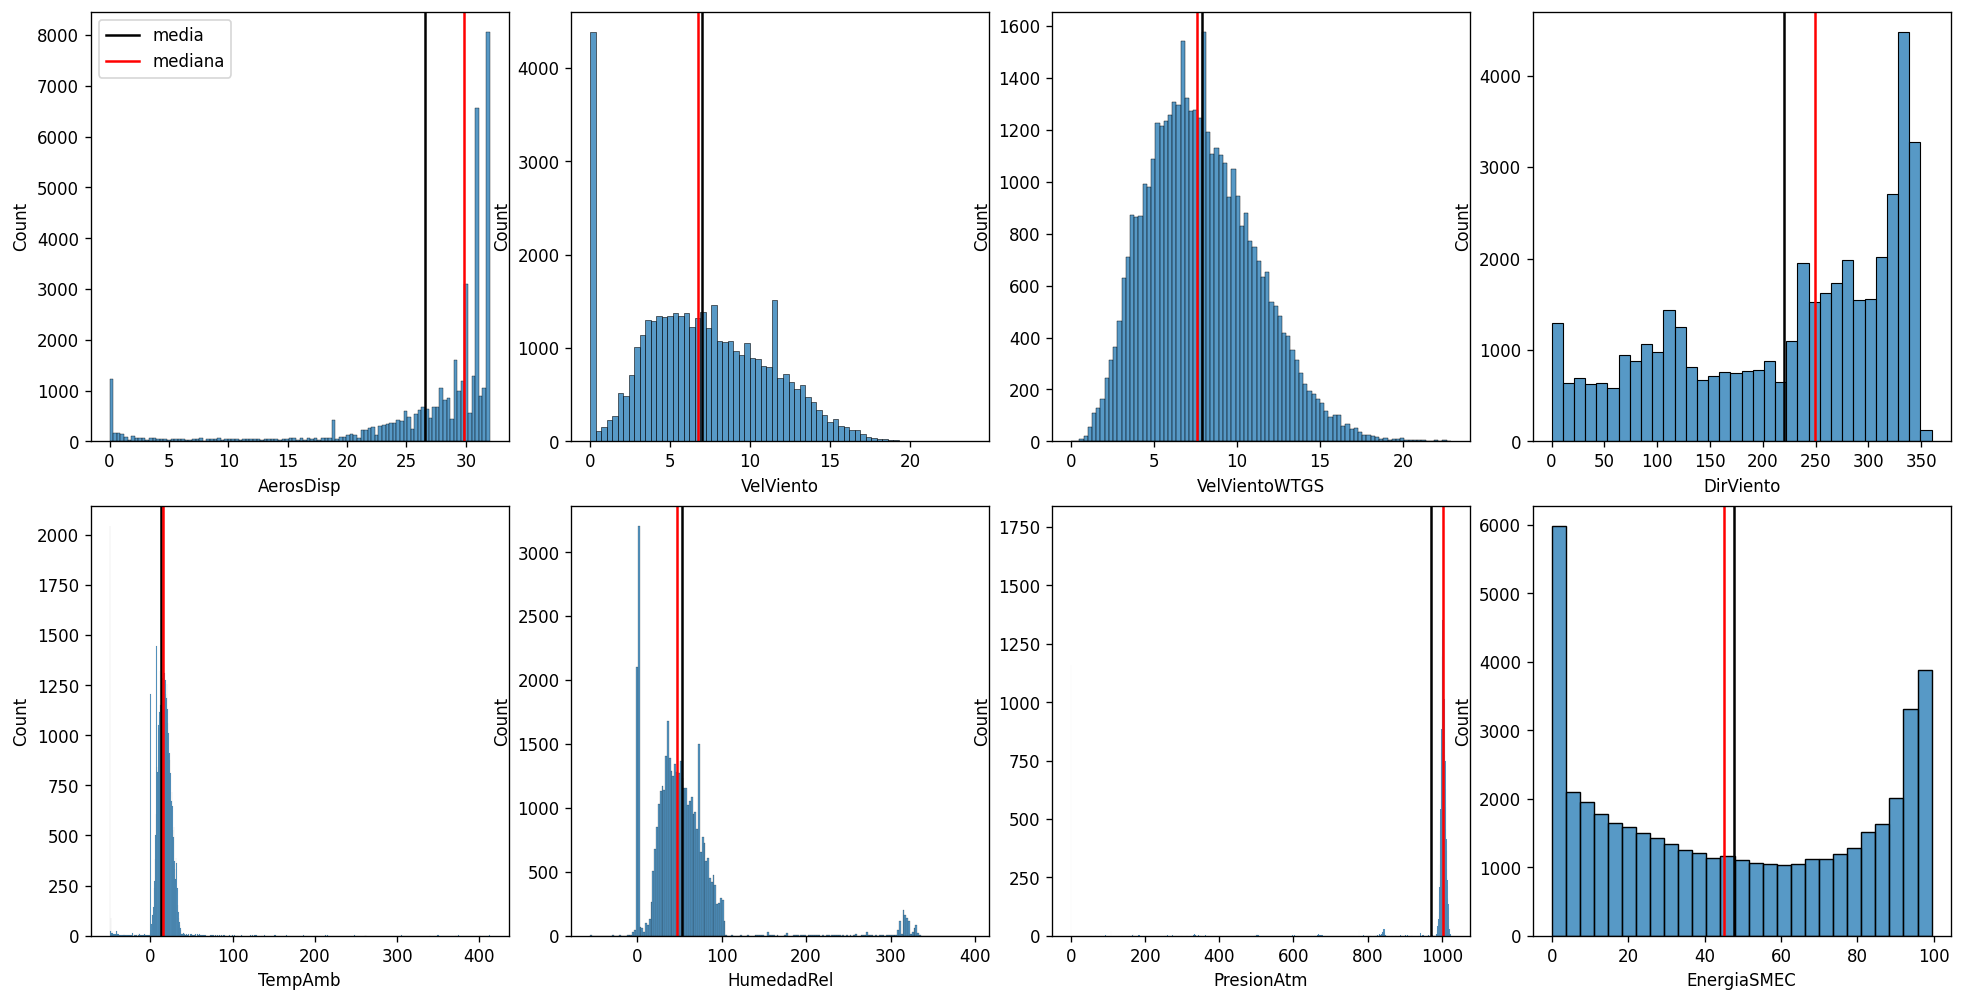

In [12]:
# Distribuciones para cada variable numerica
f, ax = plt.subplots(2, 4, figsize=(20, 10), gridspec_kw={'wspace': 0.15, 'hspace': 0.15})
ax = ax.ravel()

for i, col in enumerate(num_vars):
    sns.histplot(df[col].astype(float), ax=ax[i], kde=False)
    ax[i].axvline(x=df[col].mean(), color='k', label='media')
    ax[i].axvline(x=df[col].median(), color='r', label='mediana')

# Turn off the last subplot if needed
if len(num_vars) < len(ax):
    ax[len(num_vars)].remove()

ax[0].legend()


In [13]:
df[num_vars].describe().T

,count,mean,std,min,25%,50%,75%,max
AerosDisp,43485.0,26.590290,7.891548,0.00,25.670,29.83,31.000,32.00
VelViento,43459.0,6.964705,4.158332,0.00,3.940,6.74,10.020,23.78
VelVientoWTGS,43461.0,7.900356,3.238435,0.00,5.500,7.60,10.010,22.87
DirViento,43459.0,220.243480,105.141285,0.00,125.075,249.21,316.055,359.86
TempAmb,43459.0,13.393303,18.237190,-49.75,10.090,15.84,21.730,412.50
HumedadRel,43459.0,53.513666,50.521100,-55.52,29.780,47.38,67.820,394.40
PresionAtm,43459.0,971.298408,169.904135,0.00,999.720,1003.85,1008.030,1024.66
EnergiaSMEC,46399.0,47.652083,34.604288,-0.07,14.240,45.15,82.970,99.44


Como se puede observar hay valores inconsistentes por los picos y outliers en todas las variables meteorológicas

### Limpieza de valores repetidos inconsistentes y de outliers de las variables meteorologicas 

##### 1. Limpieza de la principal varible de VelVientoWTGS: 
Se le dara un tratamiento separado al resto de las variables por que los datos cuentan con mayor calidad y correlacion con la generación de Energia Eolica. 

In [14]:
#Borro los registros que tiene valor nulo, se presentan para todas las variables meteorolicas sin distinción de la VelVientoWTGS
df_aux=df.dropna(subset=['VelViento'])
#reseteo el indice
df_aux.reset_index(inplace=True)

In [15]:
#Verifico que no quedan nulos
df_aux.isnull().sum()

index                    0
FechaHora                0
EnergiaTGW               0
AerosDisp                0
VelViento                0
VelVientoWTGS            0
DirViento                0
TempAmb                  0
HumedadRel               0
PresionAtm               0
EnergiaSMEC              0
PronosticoCammesa    11874
ErrorPronostico      11874
dtype: int64

Analizo y remuevo valores repetidos para 'VelVientoWTGS', cuando el valor se repite al menos 5 horas consecutivas

In [16]:
df_aux=remover_valores_repetidos(df_aux, 'FechaHora', 'VelVientoWTGS', 5,'y')

Se removieron 666 registros repetidos
Remueve el valor 9.75 repetido 45 veces: 2021-01-05 08:00:00 - 2021-01-07 04:00:00
Remueve el valor 6.72 repetido 167 veces: 2021-10-14 09:00:00 - 2021-10-21 07:00:00
Remueve el valor 8.67 repetido 12 veces: 2021-11-10 22:00:00 - 2021-11-11 09:00:00
Remueve el valor 5.09 repetido 81 veces: 2022-11-11 04:00:00 - 2022-11-14 12:00:00
Remueve el valor 7.96 repetido 361 veces: 2023-08-02 10:00:00 - 2023-08-17 10:00:00


Como se puede observar en 5 rango de fechas se encontraron valores repetidos, y fueron eliminados para no considerarlos en el promedio

Calculo del valor promedio de la VelVientoWTGS cada saltos discretos del 0,5 MW de la EnergiaSMEC

In [17]:
# Discretizo la EnergiaSMEC cada saltos de 0.5 MW
df['EnergiaSMEC_discreta'] = df['EnergiaSMEC'].apply(lambda x: round(x * 2) / 2)
df_aux['EnergiaSMEC_discreta'] = df_aux['EnergiaSMEC'].apply(lambda x: round(x * 2) / 2)

In [18]:
# Calculo la media de 'VelVientoWTGS' para los valores discretos de EnergiaSMEC
df_VelVientoWTGS_mean = df_aux[['EnergiaSMEC_discreta','VelVientoWTGS']].groupby('EnergiaSMEC_discreta').mean().reset_index()

In [19]:
df_VelVientoWTGS_mean.head()

,EnergiaSMEC_discreta,VelVientoWTGS
0,0.0,2.739524
1,0.5,3.566703
2,1.0,3.674717
3,1.5,3.880053
4,2.0,3.923065


In [20]:
# Realizo la unión de los DataFrames en base a las columna 'EnergiaSMEC_discreta'
df_clean = df.merge(df_VelVientoWTGS_mean, 
                 on=['EnergiaSMEC_discreta'], 
                 how='left', suffixes = ('', '_mean'))

In [21]:
df_clean.head()

,FechaHora,EnergiaTGW,AerosDisp,VelViento,VelVientoWTGS,DirViento,TempAmb,HumedadRel,PresionAtm,EnergiaSMEC,PronosticoCammesa,ErrorPronostico,EnergiaSMEC_discreta,VelVientoWTGS_mean
0,2019-01-01 01:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,94.82,NaN,NaN,95.0,12.240547
1,2019-01-01 02:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,94.83,NaN,NaN,95.0,12.240547
2,2019-01-01 03:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,94.81,NaN,NaN,95.0,12.240547
3,2019-01-01 04:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,94.80,NaN,NaN,95.0,12.240547
4,2019-01-01 05:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,94.83,NaN,NaN,95.0,12.240547


In [22]:
# La funcion rango_fechas_repe devuelve los data_range con los periodos de fecha 
# que presentan valores repetidos consecutivos
dr=rango_fechas_repe(df, 'FechaHora', 'VelVientoWTGS', 5,'n')

Existen 666 registros repetidos


In [23]:
#Imputo el valor medio de la VelVientoWTGS para los rangos de fechas donde 
#hay valores repetidos

for prev_value, rep_count, start, end in dr:
        # Filtro por el rango de fechas
        mask = (df_clean['FechaHora'] >= start) & (df_clean['FechaHora'] <= end)

        # Actualizo los valores medios
        df_clean.loc[mask, 'VelVientoWTGS'] = df_clean.loc[mask, 'VelVientoWTGS_mean']

##### 2. Limpieza de la varible de DirViento, segunda en importancia: 
Debido a que la variable DirViento no presenta outliers, pero si valores repetidos se le da un tratamiento separado al resto de las variable meteorologicas

Analizo y remuevo valores repetidos para 'DirViento', cuando el valor se repite al menos 5 horas consecutivas

In [24]:
df_aux=remover_valores_repetidos(df_aux, 'FechaHora', 'DirViento', 5,'n')

Se removieron 5430 registros repetidos


In [25]:
# Calcula el promedio circular ponderado por la VelViento agrupando por EnergySMEC
DirViento_grouped_means = df_aux.groupby('EnergiaSMEC_discreta').apply(lambda x: weighted_circular_mean(x['DirViento'], x['VelVientoWTGS']), include_groups=True)

# Alinea la media calculada con el index de df_mean_meteo
df_clean['DirViento_mean'] = df_clean['EnergiaSMEC_discreta'].map(DirViento_grouped_means)

In [26]:
# La funcion rango_fechas_repe devuelve los data_range con los periodos de fecha 
# que presentan valores repetidos consecutivos
dr=rango_fechas_repe(df, 'FechaHora', 'DirViento', 5,'n')

Existen 6096 registros repetidos


In [27]:
#Imputo el valor medio de la DirViento para los rangos de fechas donde 
#hay valores repetidos

for prev_value, rep_count, start, end in dr:
        # Filtro por el rango de fechas
        mask = (df_clean['FechaHora'] >= start) & (df_clean['FechaHora'] <= end)

        # Actualizo los valores medios
        df_clean.loc[mask, 'DirViento'] = df_clean.loc[mask, 'DirViento_mean']

##### 3. Limpieza del resto de las variables meteorologicas (TempAmb, HumedadRel, PresionAtm): 
Estas variables presentan outliers y valores repetidos por eso se le da un tratamiento separado

In [28]:
#variables meteorológicas
meteo_vars=['VelViento','TempAmb','HumedadRel','PresionAtm']

In [29]:
#Elimino los registros de outliers de TempAmb
df_aux.drop(df_aux[(df_aux['TempAmb'] <= -5) | (df_aux['TempAmb'] >= 42)].index, inplace=True)

#Elimino los registros de outliers de PresionAtm
df_aux.drop(df_aux[(df_aux['PresionAtm'] <= 800) | (df_aux['PresionAtm'] >= 1200)].index, inplace=True)

#Elimino los registros de outliers de HumedadRel
df_aux.drop(df_aux[(df_aux['HumedadRel'] <= 0) | (df_aux['HumedadRel'] >= 100)].index, inplace=True)

#Elimino los registros cuando todas las variables meteorologicas son 0
df_aux.drop(df_aux[(df_aux[meteo_vars] == 0).all(axis=1)].index, inplace=True)


In [30]:
#Reviso minimos y maximos de las variables 
df_aux[num_vars].describe().T

,count,mean,std,min,25%,50%,75%,max
AerosDisp,32091.0,26.560748,8.011416,0.00,25.830,29.83,31.00,32.00
VelViento,32091.0,7.068246,4.102785,0.00,4.080,6.74,9.97,23.78
VelVientoWTGS,32091.0,7.853699,3.258070,0.53,5.420,7.53,9.99,22.87
DirViento,32091.0,223.770591,101.100209,0.00,131.435,251.05,315.99,359.86
TempAmb,32091.0,17.931443,7.244710,-4.39,12.580,17.64,22.95,41.96
HumedadRel,32091.0,50.553694,21.624212,0.06,34.420,49.09,66.02,99.98
PresionAtm,32091.0,1002.450024,18.390600,800.79,1000.315,1004.10,1008.10,1024.66
EnergiaSMEC,32091.0,47.325349,34.757930,-0.07,13.710,44.32,83.01,99.44


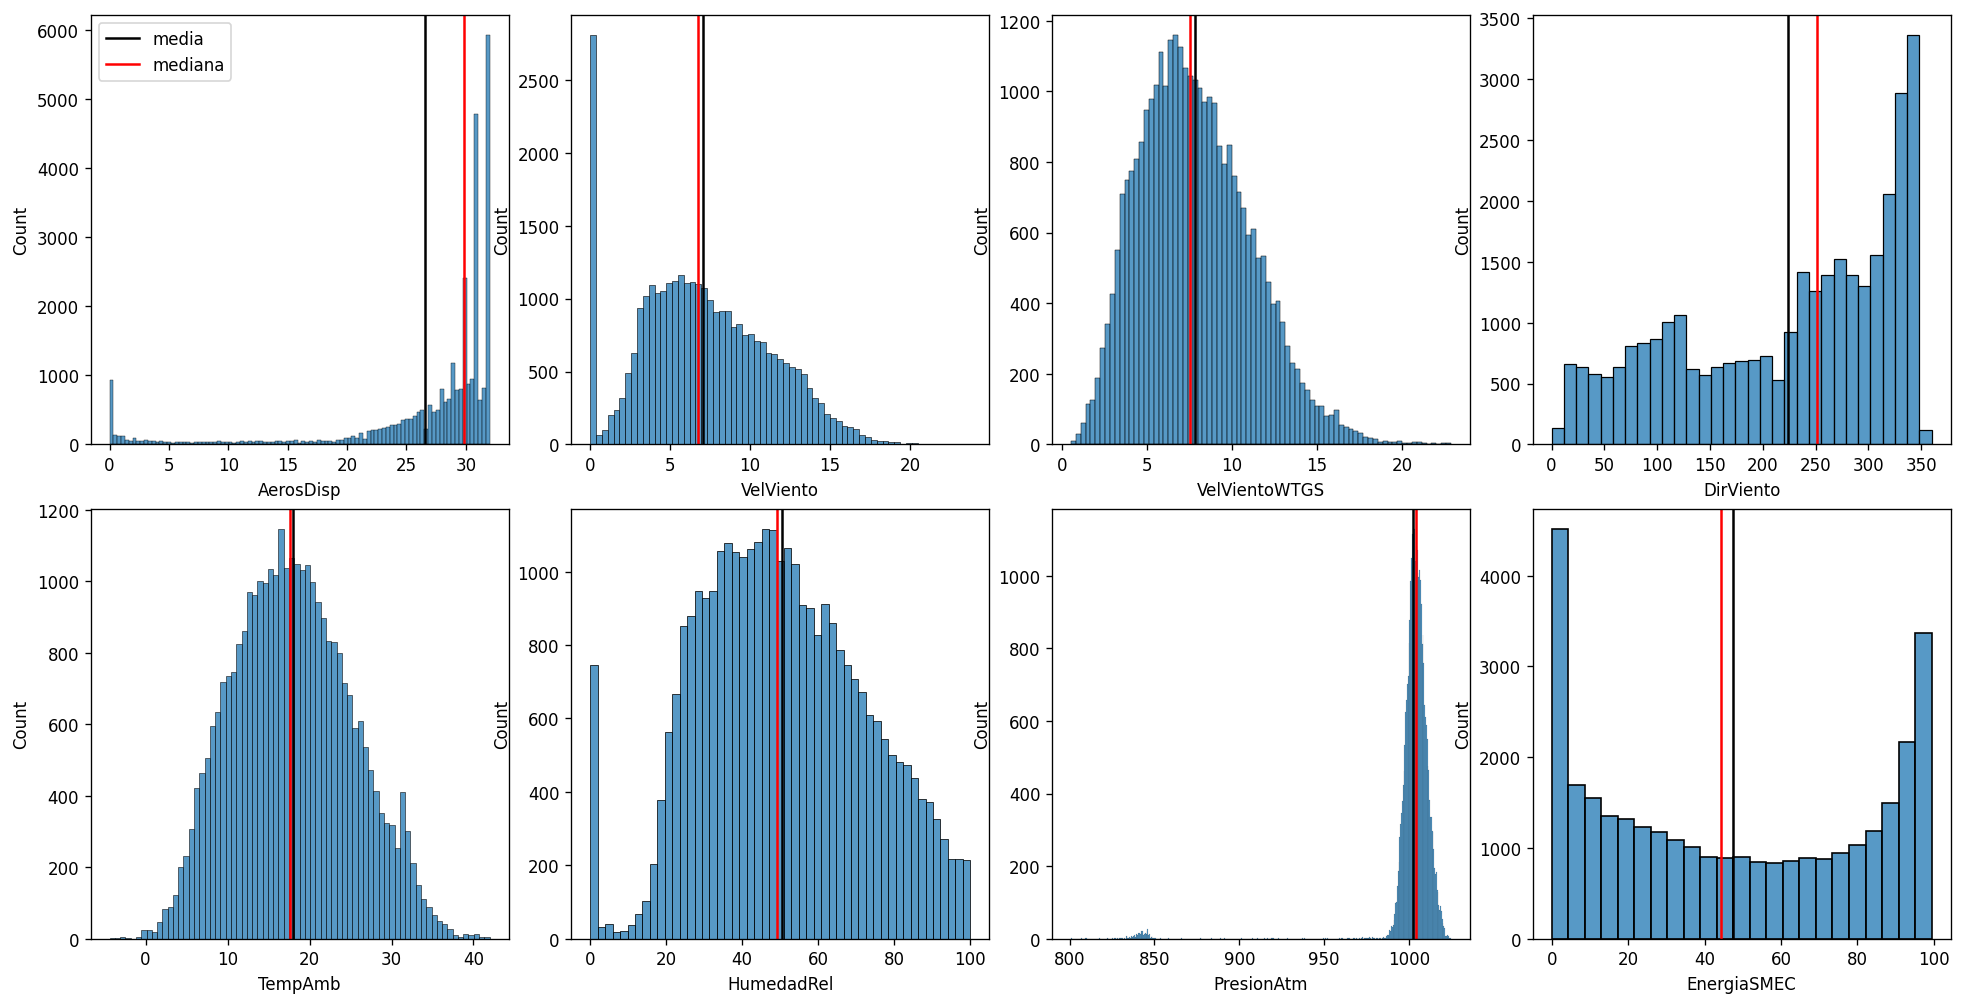

In [31]:
# Distribuciones para cada variable numerica
f, ax = plt.subplots(2, 4, figsize=(20, 10), gridspec_kw={'wspace': 0.15, 'hspace': 0.15})
ax = ax.ravel()

for i, col in enumerate(num_vars):
    sns.histplot(df_aux[col].astype(float), ax=ax[i], kde=False)
    ax[i].axvline(x=df_aux[col].mean(), color='k', label='media')
    ax[i].axvline(x=df_aux[col].median(), color='r', label='mediana')

# Turn off the last subplot if needed
if len(num_vars) < len(ax):
    ax[len(num_vars)].remove()

ax[0].legend()


In [32]:
# Calculo la media de cada columna basado en los valores discretos de EnergiaProd
meteo = ['EnergiaSMEC_discreta','VelViento','AerosDisp','TempAmb', 'HumedadRel', 'PresionAtm']

df_meteo_mean = df_aux[meteo].groupby('EnergiaSMEC_discreta').mean().reset_index()

# Merge the calculated means with df_meteo_mean on the 'EnergiaSMEC_discreta' column
df_clean = pd.merge(df_clean, df_meteo_mean, on='EnergiaSMEC_discreta', suffixes=('', '_mean'))
 

In [33]:
df_clean.head()

,FechaHora,EnergiaTGW,AerosDisp,VelViento,VelVientoWTGS,DirViento,TempAmb,HumedadRel,PresionAtm,EnergiaSMEC,PronosticoCammesa,ErrorPronostico,EnergiaSMEC_discreta,VelVientoWTGS_mean,DirViento_mean,VelViento_mean,AerosDisp_mean,TempAmb_mean,HumedadRel_mean,PresionAtm_mean
0,2019-01-01 01:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,94.82,NaN,NaN,95.0,12.240547,330.206416,12.284917,31.443917,17.467917,47.183556,1002.335528
1,2019-01-01 02:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,94.83,NaN,NaN,95.0,12.240547,330.206416,12.284917,31.443917,17.467917,47.183556,1002.335528
2,2019-01-01 03:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,94.81,NaN,NaN,95.0,12.240547,330.206416,12.284917,31.443917,17.467917,47.183556,1002.335528
3,2019-01-01 04:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,94.80,NaN,NaN,95.0,12.240547,330.206416,12.284917,31.443917,17.467917,47.183556,1002.335528
4,2019-01-01 05:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,94.83,NaN,NaN,95.0,12.240547,330.206416,12.284917,31.443917,17.467917,47.183556,1002.335528


In [34]:
# Imputo en los registors nulos de las variables meteorologicas los valores medios
df_clean['AerosDisp'].fillna(df_clean['AerosDisp_mean'], inplace=True)
df_clean['VelViento'].fillna(df_clean['VelViento_mean'], inplace=True)
df_clean['VelVientoWTGS'].fillna(df_clean['VelVientoWTGS_mean'], inplace=True)
df_clean['DirViento'].fillna(df_clean['DirViento_mean'], inplace=True)
df_clean['TempAmb'].fillna(df_clean['TempAmb_mean'], inplace=True)
df_clean['HumedadRel'].fillna(df_clean['HumedadRel_mean'], inplace=True)
df_clean['PresionAtm'].fillna(df_clean['PresionAtm_mean'], inplace=True)

# Imputo en los registors nulos de EnergiaTGW le copio la EnergiaSMEC 
df_clean['EnergiaTGW'].fillna(df_clean['EnergiaSMEC'], inplace=True)

In [35]:
#verifico si quedo algun valor nulo
df_clean.isnull().sum()

FechaHora                   0
EnergiaTGW                  0
AerosDisp                   0
VelViento                   0
VelVientoWTGS               0
DirViento                   0
TempAmb                     0
HumedadRel                  0
PresionAtm                  0
EnergiaSMEC                 0
PronosticoCammesa       12991
ErrorPronostico         12991
EnergiaSMEC_discreta        0
VelVientoWTGS_mean          0
DirViento_mean              0
VelViento_mean              0
AerosDisp_mean              0
TempAmb_mean                0
HumedadRel_mean             0
PresionAtm_mean             0
dtype: int64

In [36]:
# Utilizo la funcion rango_fechas_repe devuelve un data_range con los periodos de fecha 
# con valores repetidos en VelViento

dr=rango_fechas_repe(df, 'FechaHora', 'VelViento', 3,'y')

Existen 8919 registros repetidos
Valor 11.21 repetido 9 veces en las fechas: 2019-05-05 00:00:00 - 2019-05-05 08:00:00
Valor 3.55 repetido 12 veces en las fechas: 2019-05-07 21:00:00 - 2019-05-08 08:00:00
Valor 9.41 repetido 10 veces en las fechas: 2019-05-09 00:00:00 - 2019-05-09 09:00:00
Valor 4.07 repetido 17 veces en las fechas: 2019-05-09 18:00:00 - 2019-05-10 10:00:00
Valor 5.84 repetido 10 veces en las fechas: 2019-05-10 19:00:00 - 2019-05-11 04:00:00
Valor 6.68 repetido 3 veces en las fechas: 2019-05-11 06:00:00 - 2019-05-11 08:00:00
Valor 3.07 repetido 9 veces en las fechas: 2019-05-20 17:00:00 - 2019-05-21 01:00:00
Valor 3.07 repetido 4 veces en las fechas: 2019-05-21 05:00:00 - 2019-05-21 08:00:00
Valor 0.0 repetido 6 veces en las fechas: 2019-05-22 03:00:00 - 2019-05-22 08:00:00
Valor 4.21 repetido 11 veces en las fechas: 2019-05-30 00:00:00 - 2019-05-30 10:00:00
Valor 0.0 repetido 10 veces en las fechas: 2019-05-30 15:00:00 - 2019-05-31 00:00:00
Valor 0.0 repetido 4 veces 

In [37]:
#Imputo el valor medio de las variables meteorologicas para los rangos de fechas donde 
#hay valores repetidos
for prev_value, rep_count, start, end in dr:
        # Filtro por el rango de fechas
        mask = (df_clean['FechaHora'] >= start) & (df_clean['FechaHora'] <= end)

        # Actualizo los valores medios
        df_clean.loc[mask, 'VelViento'] = df_clean.loc[mask, 'VelViento_mean']
        df_clean.loc[mask, 'TempAmb'] = df_clean.loc[mask, 'TempAmb_mean']
        df_clean.loc[mask, 'HumedadRel'] = df_clean.loc[mask, 'HumedadRel_mean']
        df_clean.loc[mask, 'PresionAtm'] = df_clean.loc[mask, 'PresionAtm_mean']


In [38]:
#Imputo la media en los registros de outliers de TempAmb
mask = (df_clean['TempAmb'] <= -5) | (df_clean['TempAmb'] >= 40)

df_clean.loc[mask, 'TempAmb'] = df_clean.loc[mask, 'TempAmb_mean']

#Imputo media en los registros de outliers de PresionAtm
mask = (df_clean['PresionAtm'] <= 800) | (df_clean['PresionAtm'] >= 1000)

df_clean.loc[mask, 'PresionAtm'] = df_clean.loc[mask, 'PresionAtm_mean']

# Agrego la 'DirViento' en meteo_vars
meteo_vars.append('DirViento')

#Imputo media en los registros que todas las variables meteorologicas son 0
mask = (df_clean[meteo_vars] == 0).all(axis=1)

# Actualizo los valores medios para todas las variables meteorologicas
df_clean.loc[mask, 'VelViento'] = df_clean.loc[mask, 'VelViento_mean']
df_clean.loc[mask, 'DirViento'] = df_clean.loc[mask, 'DirViento_mean']
df_clean.loc[mask, 'TempAmb'] = df_clean.loc[mask, 'TempAmb_mean']
df_clean.loc[mask, 'HumedadRel'] = df_clean.loc[mask, 'HumedadRel_mean']
df_clean.loc[mask, 'PresionAtm'] = df_clean.loc[mask, 'PresionAtm_mean']


In [39]:
df_clean=df_clean.iloc[:,0:11]

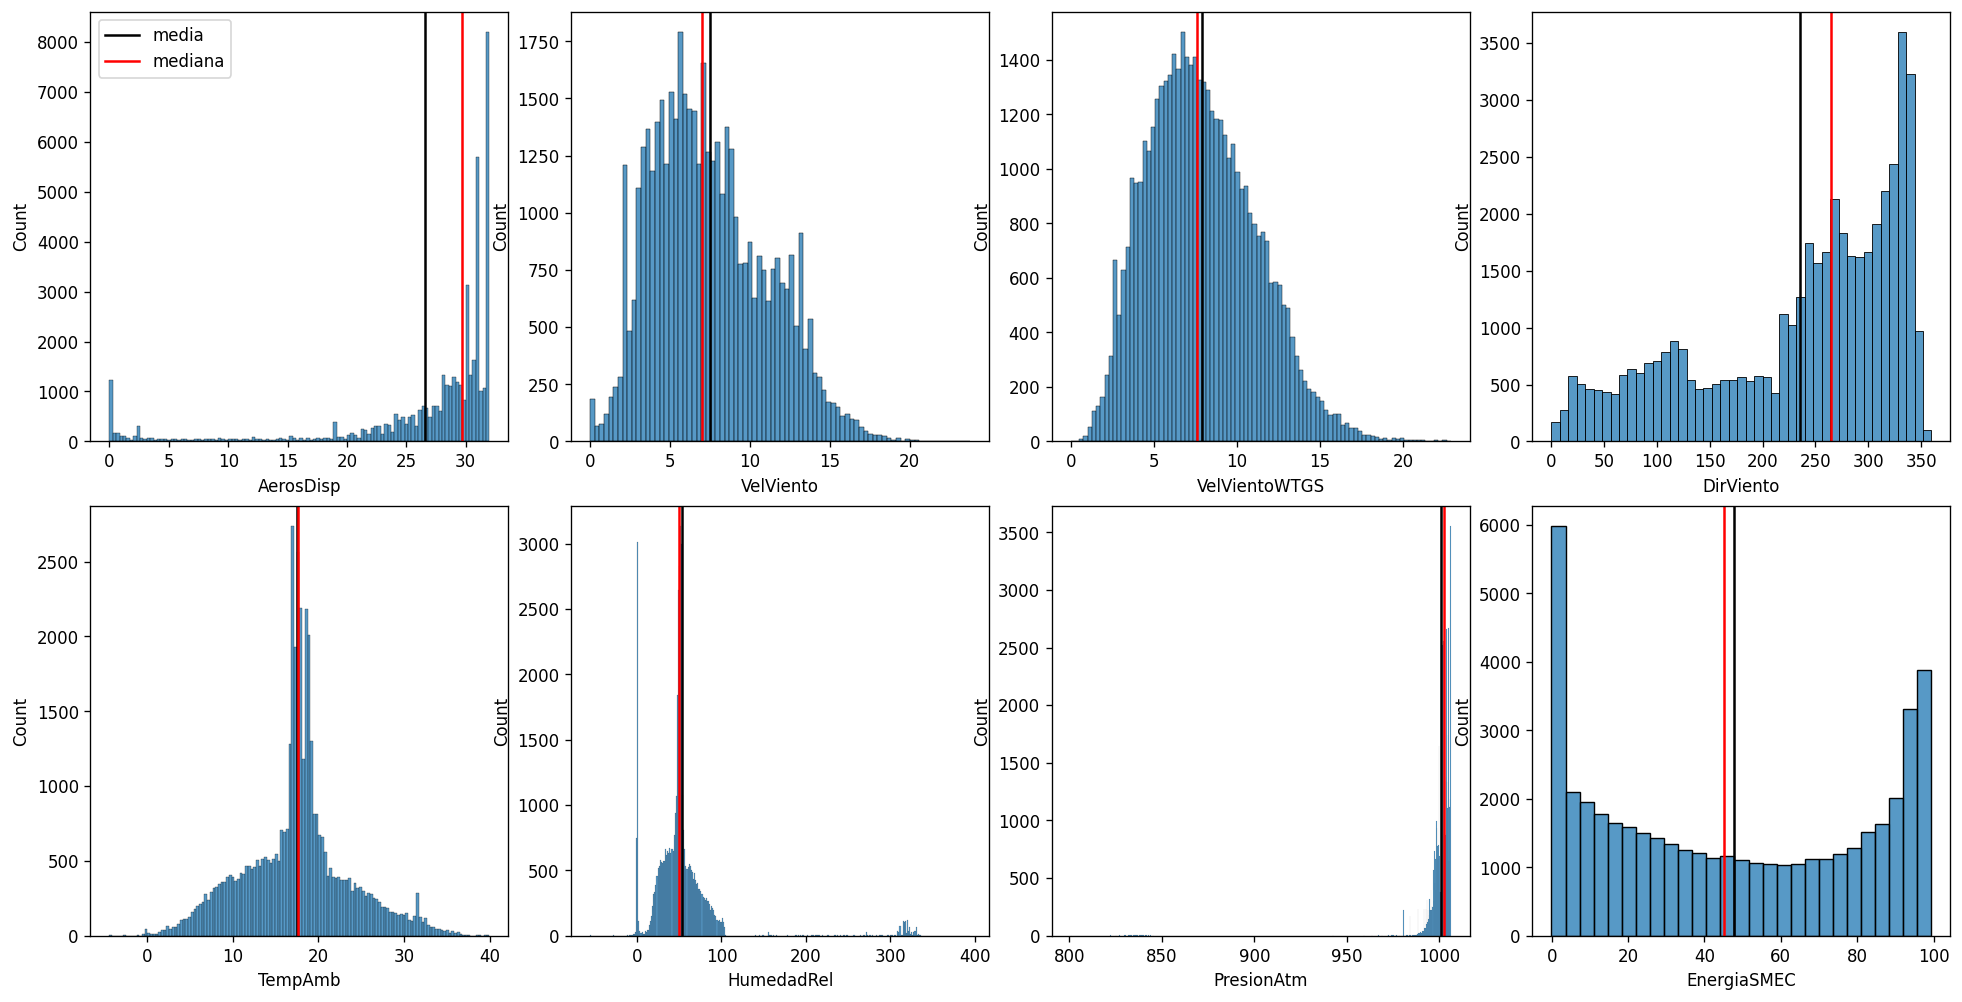

In [40]:
# Distribuciones para cada variable numerica
f,ax = plt.subplots(2,4,figsize=(20,10),gridspec_kw={'wspace':0.15,'hspace':0.15})

ax = ax.ravel()
for i,col in enumerate(num_vars):
    sns.histplot(df_clean[col].astype(float),ax=ax[i],kde=False)
    ax[i].axvline(x=df_clean[col].mean(),color='k',label='media')
    ax[i].axvline(x=df_clean[col].median(),color='r',label='mediana')    
# Turn off the last subplot
if len(num_vars) < len(ax):
    ax[len(num_vars)].remove()
   
ax[0].legend();

Como se puede observar en los histogramas el dataframe df_clean al reemplazar los valores inconsistentes de las variables metereológicas e imputarle la media en algunos casos se generan picos en las medias

<Axes: >

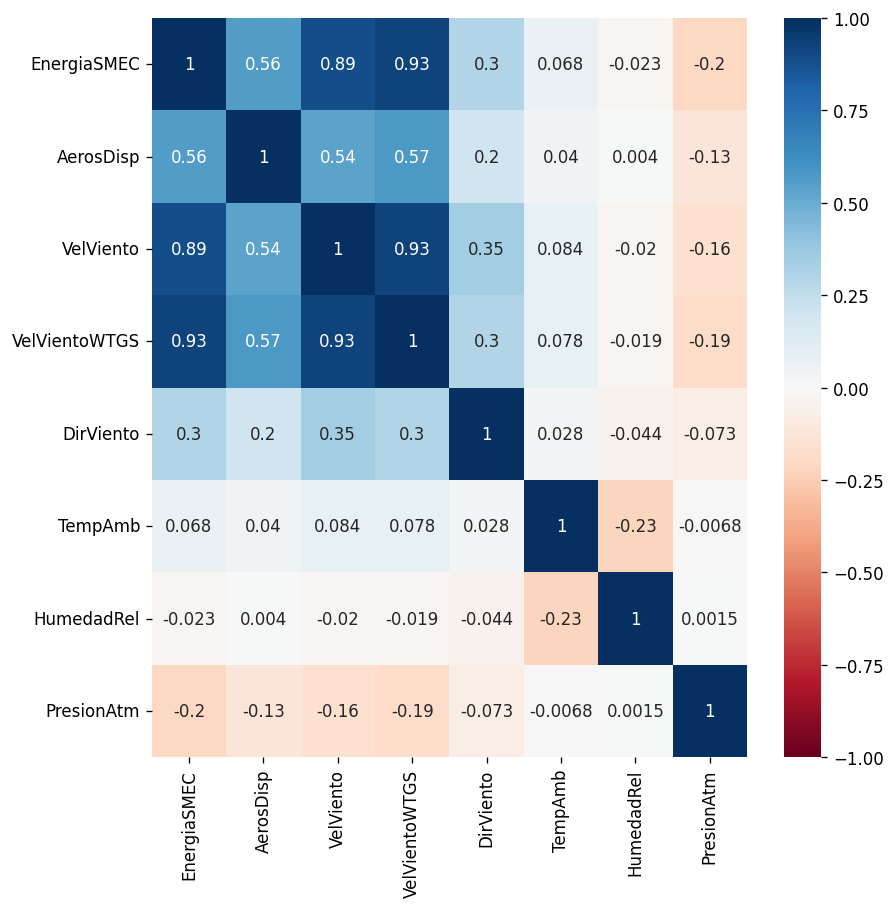

In [41]:
#Matriz de Correlacion
key_vars = ['EnergiaSMEC','AerosDisp','VelViento','VelVientoWTGS','DirViento','TempAmb','HumedadRel','PresionAtm']

plt.figure(figsize=(8,8))
sns.heatmap(df_clean[key_vars].corr(),annot=True,cmap='RdBu',vmin=-1)

En la matriz de correlacion se observa claramente la fuerte correlacion entre la Genracion y la velocidad del viento y los Aerogeneradores disponibles, en menor medida la direccion y aun menor la temperatura. Lo cual es totalmente razonable la correlacion con las variables de viento y disponibilidad de maquina, en el caso de la temperatura ambiente la correlacion esta asociada a lo que se conoce en la practica como derrating de temperatura perdida de eficiencia a medida que aumenta la temperatura 

In [42]:
#dejo el archivo en un csv para analizar los datos limpios
#df_clean.to_csv('D:\\Documents\\MMA\\1.0 Tesis\\Datos\\df_clean_lac.csv', sep=';', index=False, decimal=',')

In [43]:
df_clean.shape

(46399, 11)

### Extraccion de datos climaticos historicos desde Meteostat 
Se toman de la estación meteorologica del Aerodromo de Bahia Blanca que se encuentra a 30 Km del PE La Castellana

In [44]:
# Get nearby weather stations
stations = Stations()

#Aerodromo de Bahia Blanca a 30 Km de La Castellana I
station_ba = stations.nearby(-38.7333, -62.1667) 
station_ba = station_ba.fetch(1)

# Print DataFrame
print(station_ba)

                         name country region    wmo  icao  latitude  \
id                                                                    
87750  Bahia Blanca Aerodrome      AR      B  87750  SAZB  -38.7333   

       longitude  elevation                        timezone hourly_start  \
id                                                                         
87750   -62.1667       75.0  America/Argentina/Buenos_Aires   1939-04-10   

      hourly_end daily_start  daily_end monthly_start monthly_end  distance  
id                                                                           
87750 2024-03-27  1956-02-02 2024-12-30    1956-01-01  2021-01-01       0.0  


In [45]:
# Set time period Mask
start = datetime(2019, 1, 2)
#end = datetime(2024, 3, 31)


# Calcula end_date como la fecha actual + 11 días para incluir datos del pronostico
current_date = datetime.now().date()
end_date = current_date + timedelta(days=11)

# Convierte a datetime con la hora establecida a medianoche
end = datetime.combine(end_date, datetime.min.time())

print("End date:", end)

End date: 2024-04-28 00:00:00


In [46]:
# Create Point for Bahia Blanca
station_ba = 87750  

# Get daily data Bahia Blanca
data_met_ba = Hourly(station_ba, start, end)
#data_met_ba = data_met_ba.normalize()
data_met_ba = data_met_ba.fetch()

# Time Zone Correction Subtract 3 hours from the DateTimeIndex - UTC Buenos Aires
data_met_ba.index = data_met_ba.index - pd.to_timedelta(3, unit='h')

#Wind speed esta en Km/h lo convierto a m/s
data_met_ba['wspd_ms'] = (data_met_ba['wspd'] / 3.6).round(1)


data_met_ba = data_met_ba[[ 'wspd_ms', 'wdir', 'temp','pres','rhum']]

data_met_ba.tail()

,wspd_ms,wdir,temp,pres,rhum
time,,,,,
2024-04-26 03:00:00,4.1,327.0,8.1,1016.9,88.0
2024-04-26 04:00:00,4.1,328.0,8.0,1016.8,88.0
2024-04-26 05:00:00,4.1,327.0,7.9,1016.7,88.0
2024-04-26 06:00:00,3.6,327.0,7.8,1016.8,88.0
2024-04-26 07:00:00,3.6,327.0,8.0,1016.8,87.0


In [47]:
data_met_ba.index.name = 'FechaHora'

In [48]:
# Realizo la unión de los DataFrames

df_clean_met = data_met_ba.merge(df_clean, 
                 on=['FechaHora'],
                 how='left')


In [49]:
df_clean_met.shape

(46595, 16)

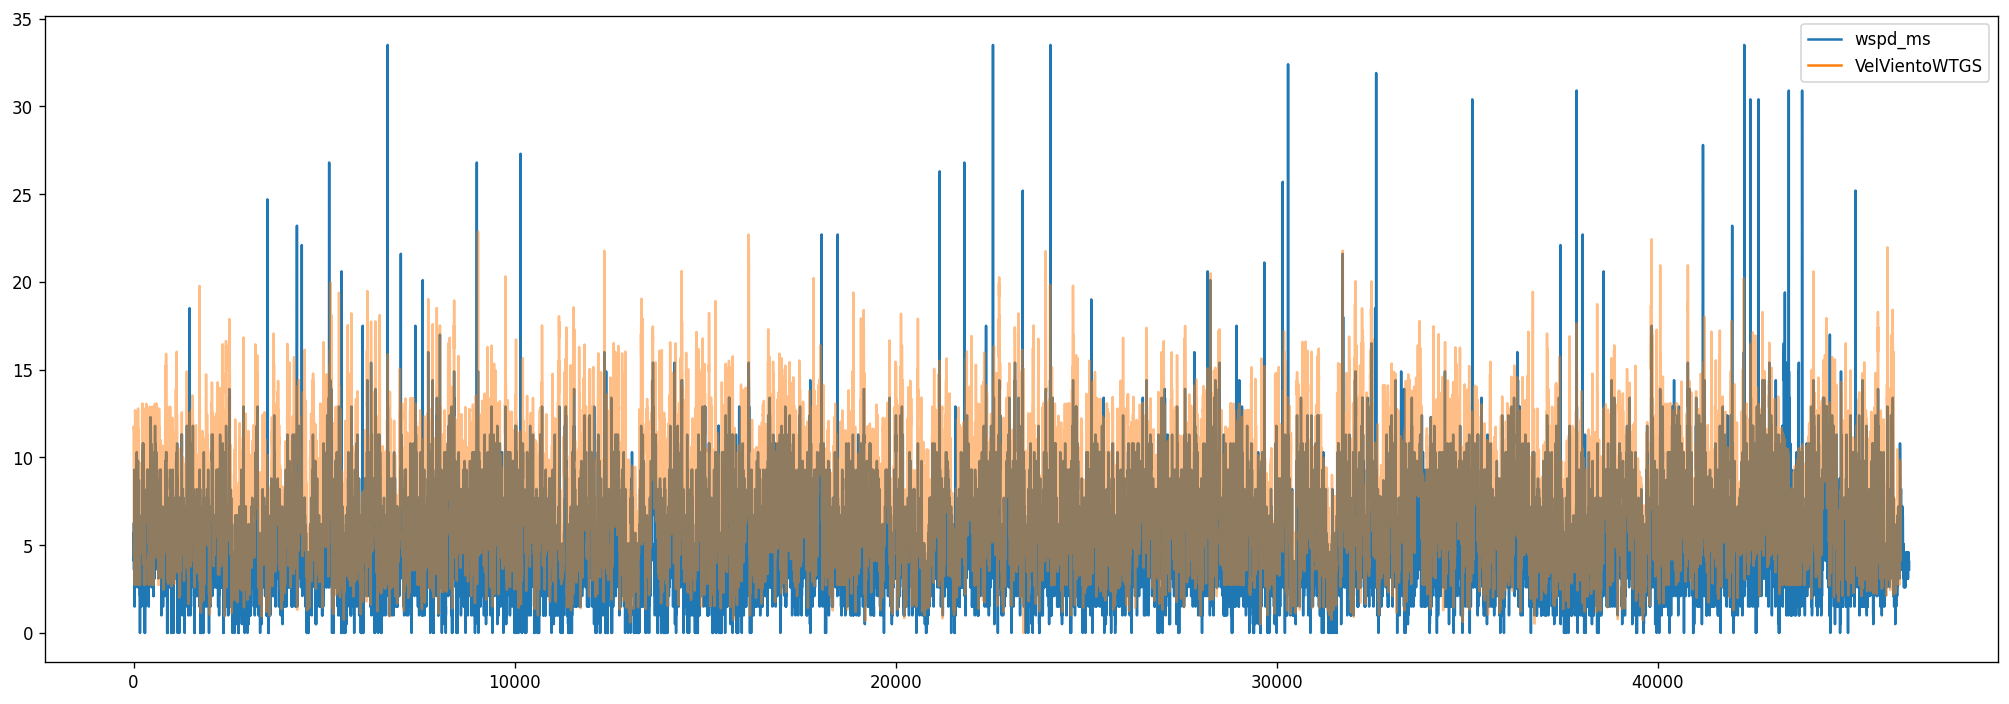

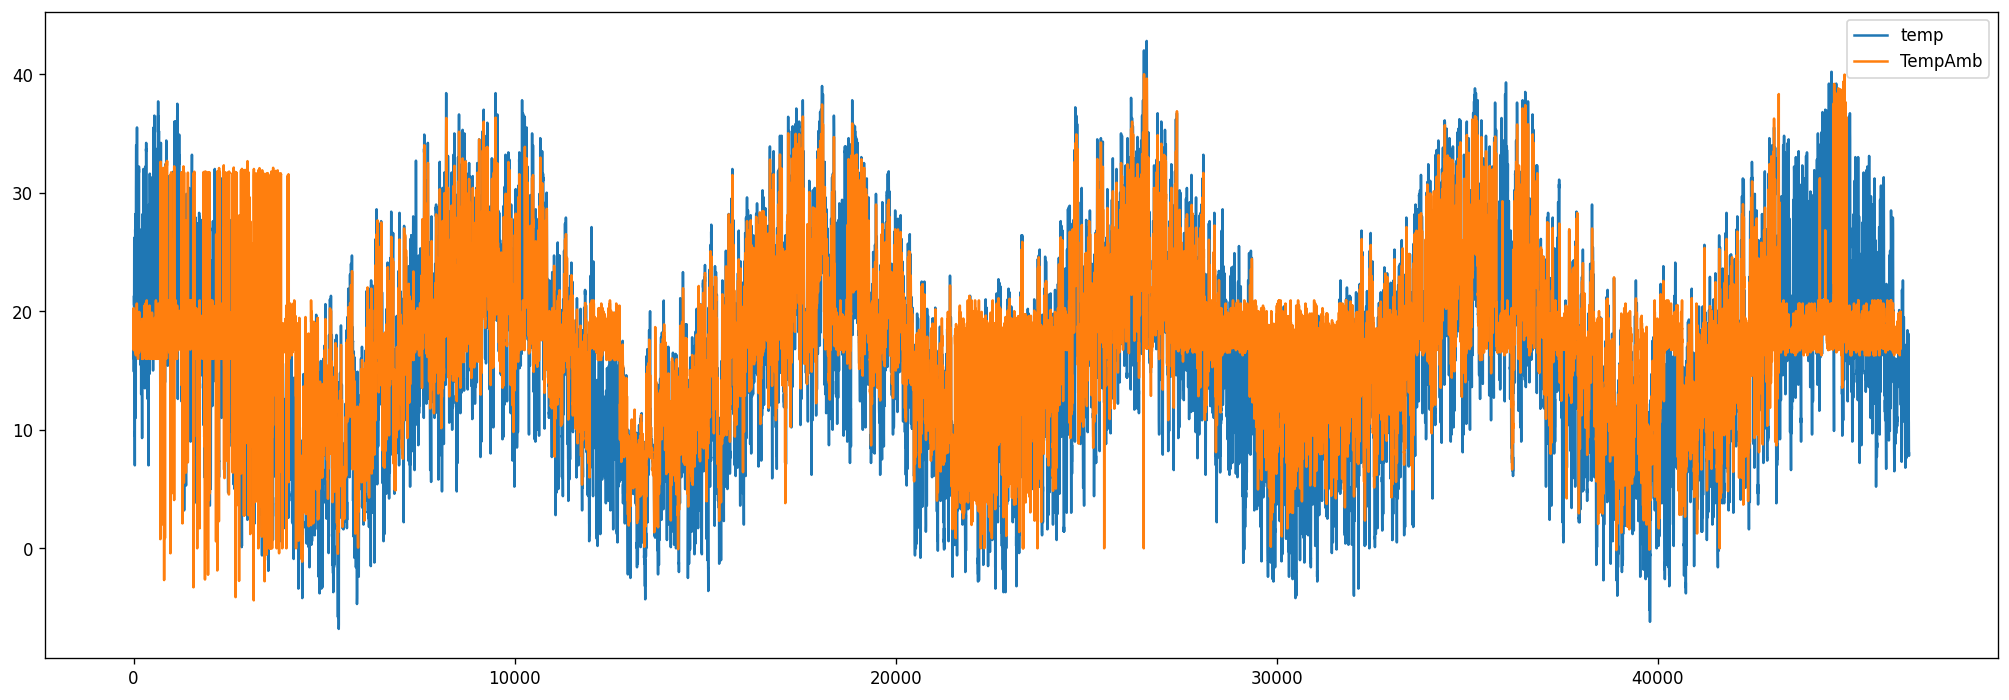

In [50]:
# Plotting specific columns
ax = df_clean_met.plot(y=['wspd_ms', 'VelVientoWTGS'])  # Plot both columns

# Adjusting the transparency of a specific line (VelViento) after plotting
lines = ax.get_lines()  # Get the lines in the plot
lines[1].set_alpha(0.5)  # Set transparency (alpha) of the second line (VelViento) to 0.5

df_clean_met.plot(y=['temp','TempAmb'])

plt.show()

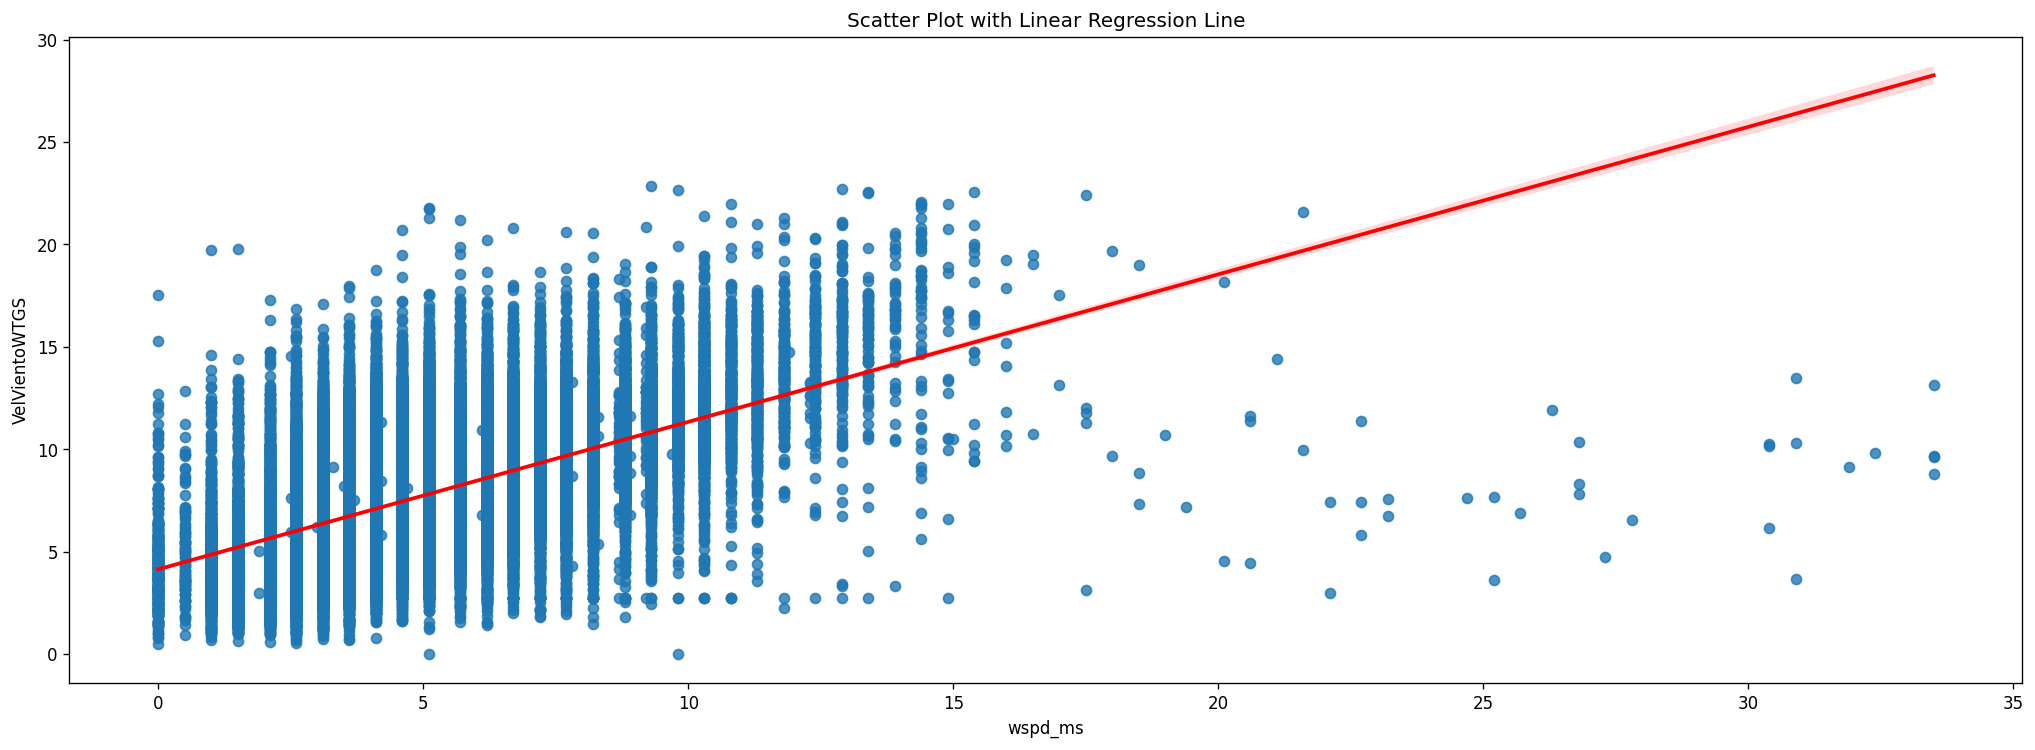

In [51]:
# Scatter plot
sns.regplot(x='wspd_ms', y='VelVientoWTGS', data=df_clean_met, line_kws={'color': 'red'})
plt.xlabel('wspd_ms')
plt.ylabel('VelVientoWTGS')
plt.title('Scatter Plot with Linear Regression Line')
plt.show()


#### Distribucion de la velocidad de viento (wspd_ms) extraida de MeteoStat para Bahia Blanca

<Axes: xlabel='wspd_ms', ylabel='Count'>

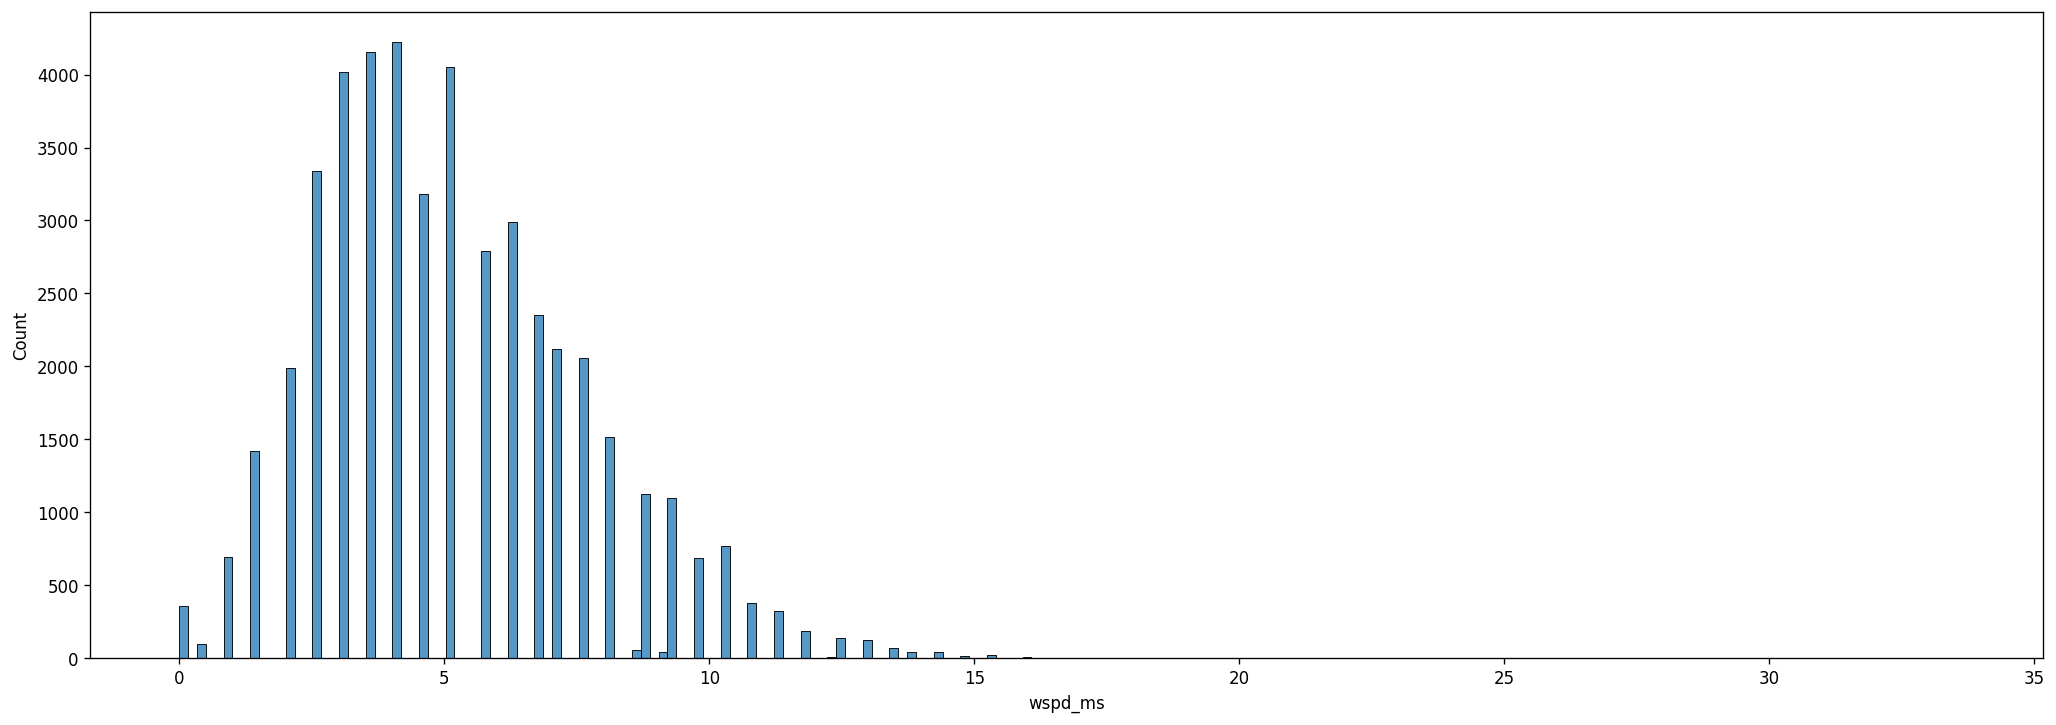

In [52]:
sns.histplot(data_met_ba['wspd_ms'].astype(float),kde=False, bins=200)

#### Distribucion de la velocidad de viento (VelViento) del parque La Castellana

<Axes: xlabel='VelVientoWTGS', ylabel='Count'>

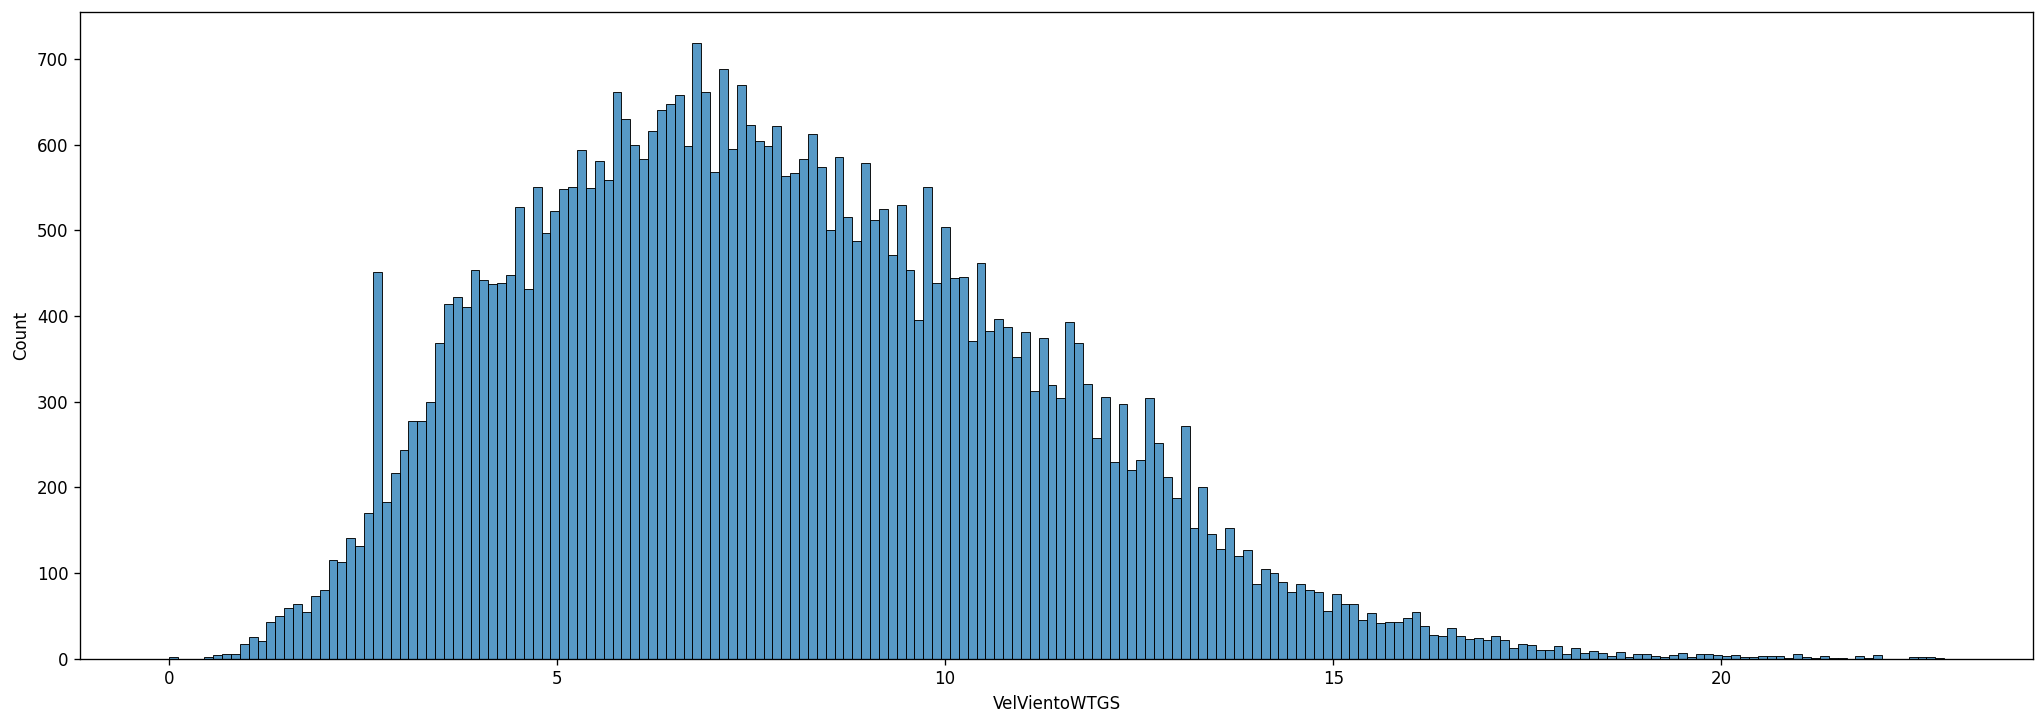

In [53]:
sns.histplot(df_clean['VelVientoWTGS'].astype(float),kde=False, bins=200)

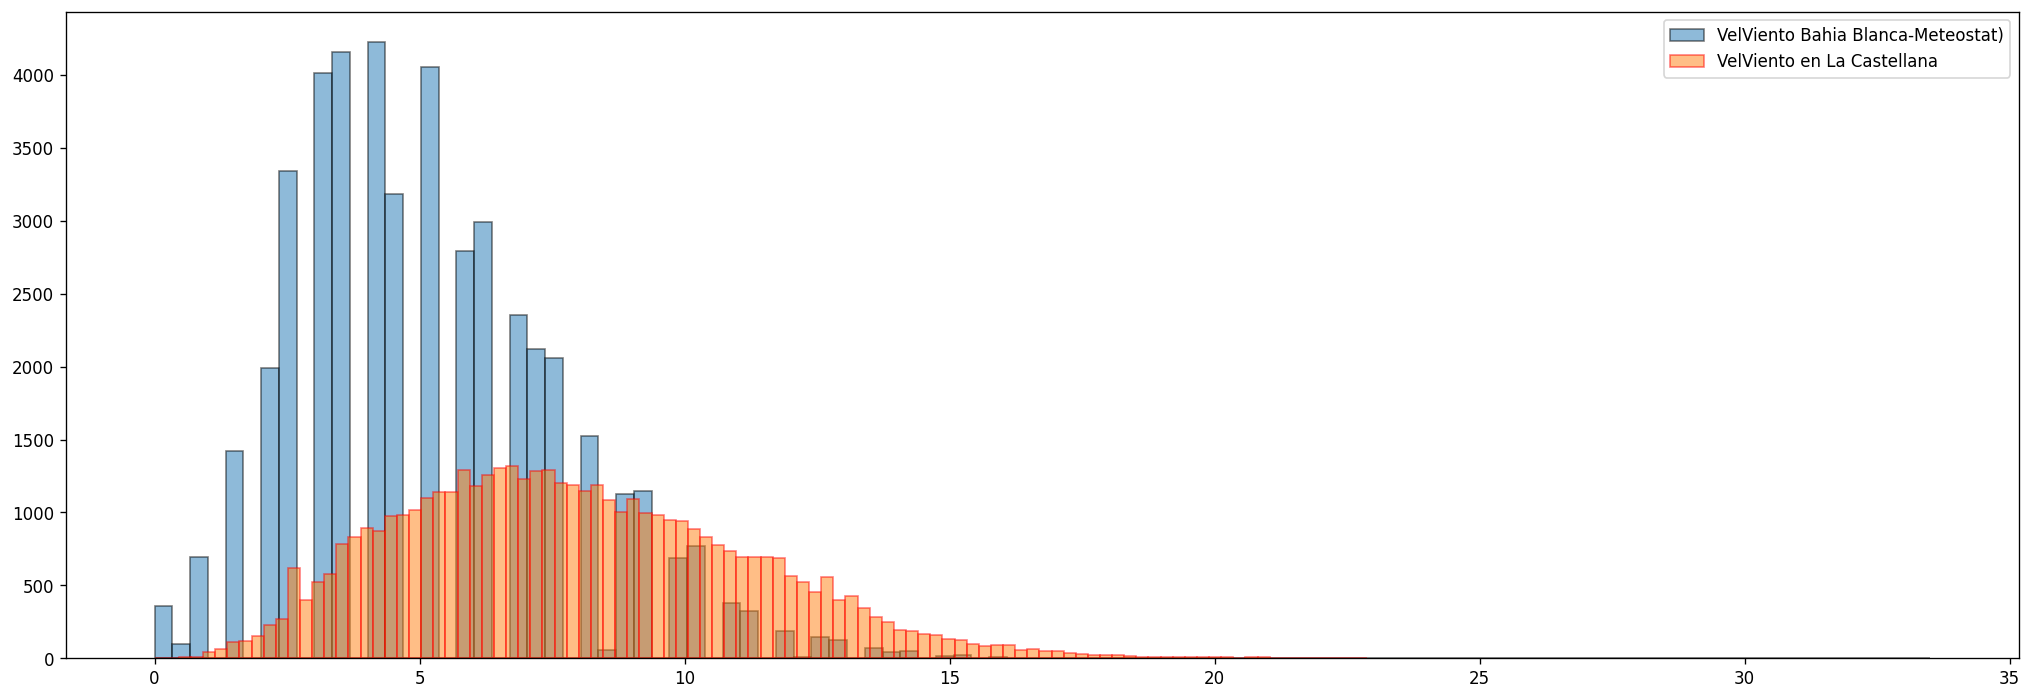

In [54]:
plt.hist(df_clean_met['wspd_ms'], edgecolor='black', alpha=0.5, label='VelViento Bahia Blanca-Meteostat)', bins=100)  # Solid line for Variable 1
plt.hist(df_clean_met['VelVientoWTGS'], edgecolor='red', alpha=0.5, label='VelViento en La Castellana', bins=100)  # Solid line for Variable 2
plt.legend()
plt.show()

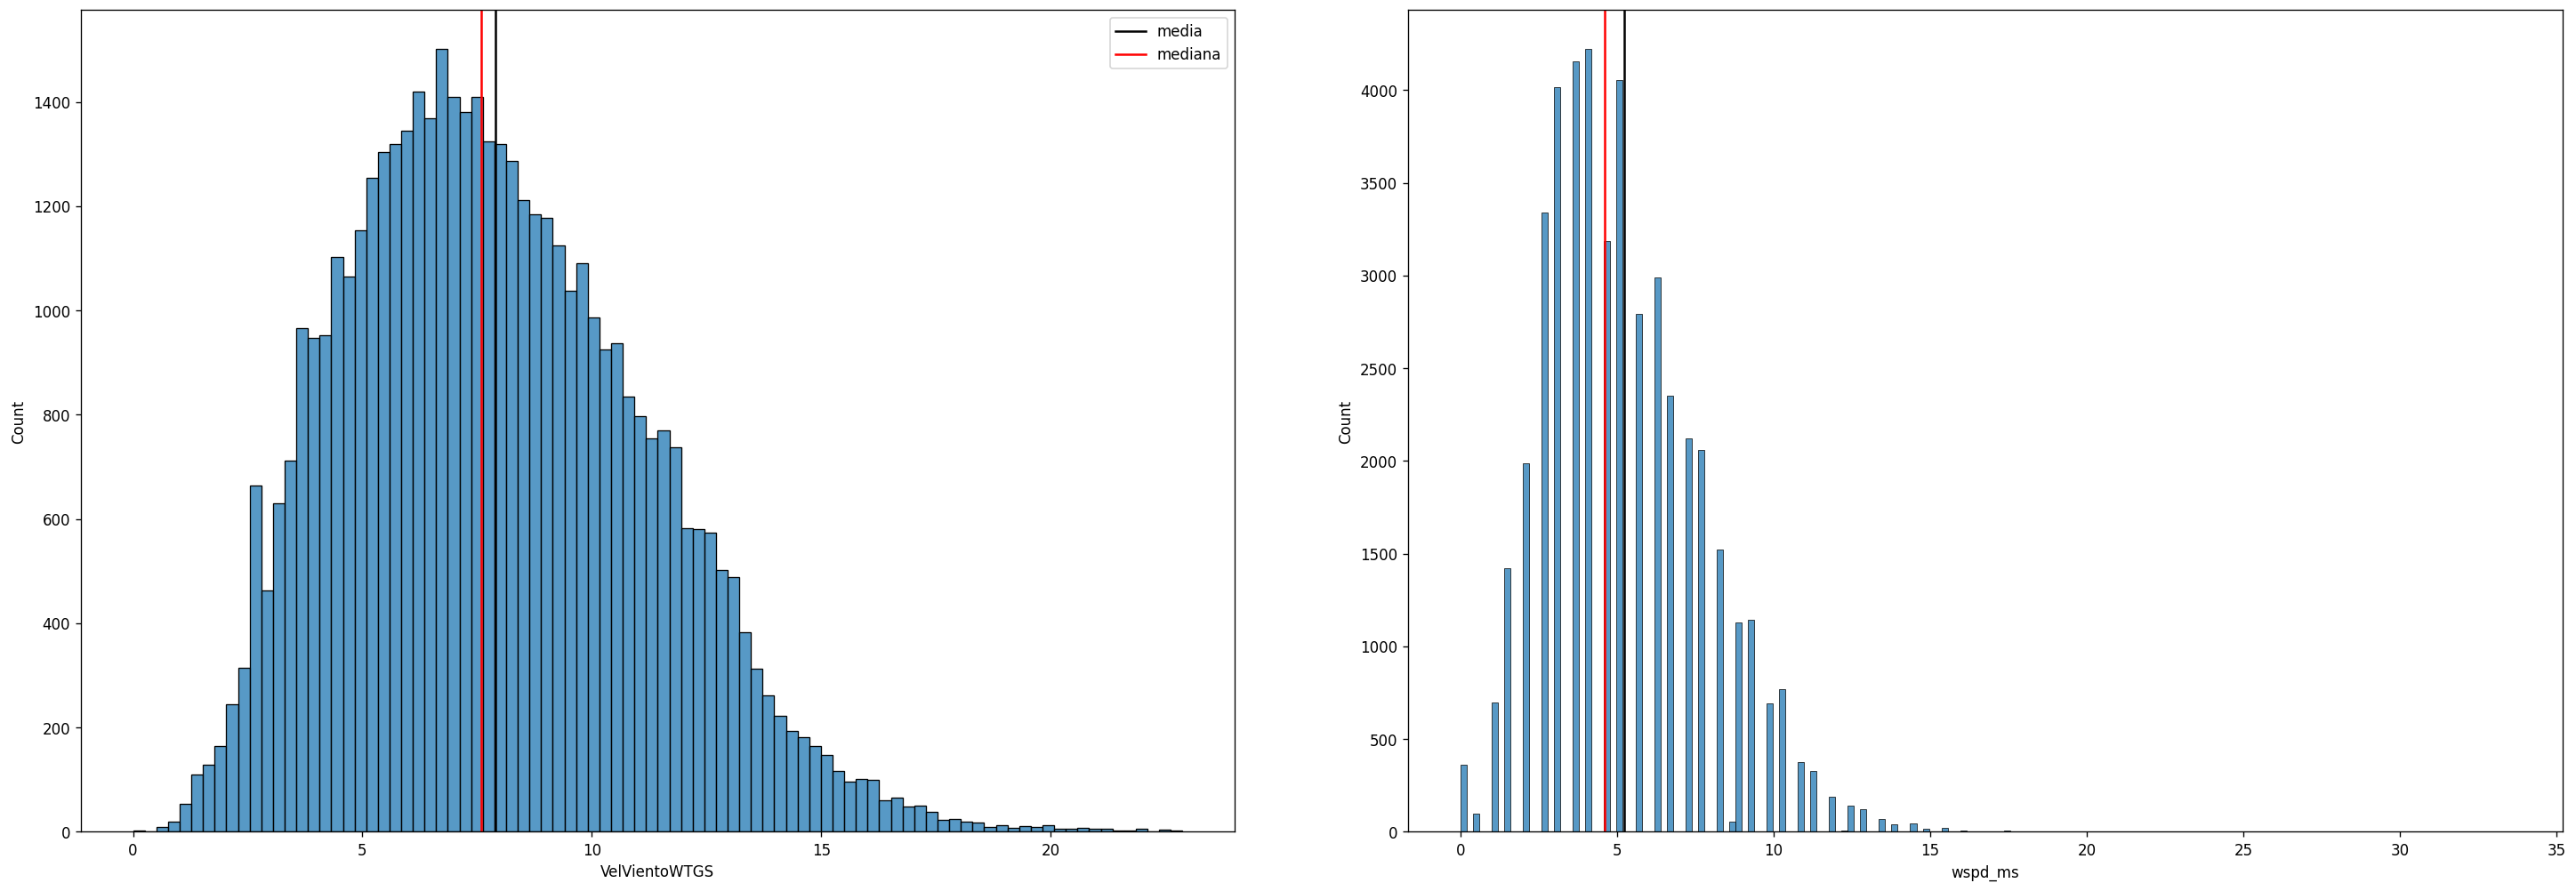

In [55]:
num_vars_met = ['VelVientoWTGS','wspd_ms'] #,'wspd_ms_rc_ajus'

# Distribuciones para cada variable numerica
f,ax = plt.subplots(1,2,figsize=(30,10),gridspec_kw={'wspace':0.15,'hspace':0.15})

ax = ax.ravel()
for i,col in enumerate(num_vars_met):
    sns.histplot(df_clean_met[col].astype(float),ax=ax[i],kde=False)
    ax[i].axvline(x=df_clean_met[col].mean(),color='k',label='media')
    ax[i].axvline(x=df_clean_met[col].median(),color='r',label='mediana')    
# Turn off the last subplot
if len(num_vars) < len(ax):
    ax[len(num_vars)].remove()
   
ax[0].legend();

<Axes: >

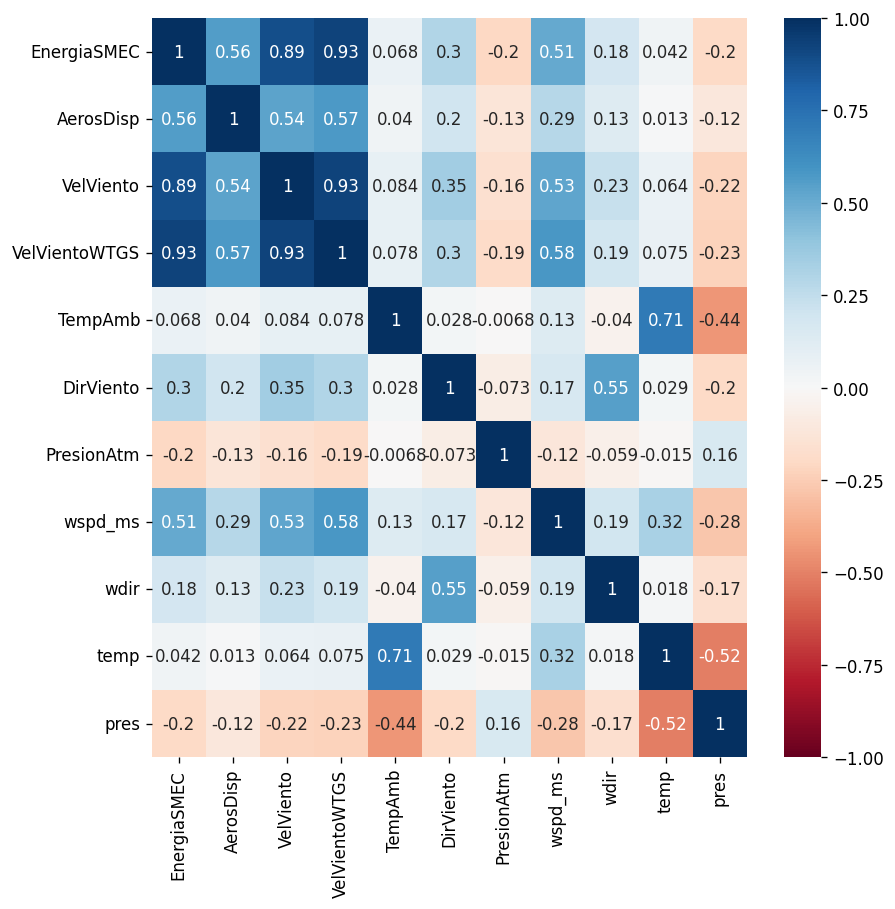

In [56]:
#Matriz de Correlacion
key_vars = ['EnergiaSMEC','AerosDisp','VelViento','VelVientoWTGS','TempAmb','DirViento','PresionAtm','wspd_ms','wdir','temp','pres']

plt.figure(figsize=(8,8))
sns.heatmap(df_clean_met[key_vars].corr(),annot=True,cmap='RdBu',vmin=-1)

In [57]:
corr_matrix = df_clean_met[key_vars].corr()
corr_matrix['EnergiaSMEC'].sort_values(ascending=False)

EnergiaSMEC      1.000000
VelVientoWTGS    0.928694
VelViento        0.889400
AerosDisp        0.559747
wspd_ms          0.511450
DirViento        0.304544
wdir             0.182404
TempAmb          0.067812
temp             0.042353
pres            -0.197394
PresionAtm      -0.204730
Name: EnergiaSMEC, dtype: float64

##### Se reduce el dataset a las variables de interes 

In [58]:
df_clean_ba=df_clean_met[['FechaHora','EnergiaSMEC','AerosDisp','VelViento','VelVientoWTGS','TempAmb','DirViento','PresionAtm','wspd_ms','wdir','temp','pres','rhum']]

In [59]:
df_clean_ba.tail()

,FechaHora,EnergiaSMEC,AerosDisp,VelViento,VelVientoWTGS,TempAmb,DirViento,PresionAtm,wspd_ms,wdir,temp,pres,rhum
46590,2024-04-26 03:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.1,327.0,8.1,1016.9,88.0
46591,2024-04-26 04:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.1,328.0,8.0,1016.8,88.0
46592,2024-04-26 05:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.1,327.0,7.9,1016.7,88.0
46593,2024-04-26 06:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.6,327.0,7.8,1016.8,88.0
46594,2024-04-26 07:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.6,327.0,8.0,1016.8,87.0


In [60]:
df_clean_rl=df_clean_ba.copy()
df_clean_rl.dropna(inplace=True)
df_clean_rl.tail()

,FechaHora,EnergiaSMEC,AerosDisp,VelViento,VelVientoWTGS,TempAmb,DirViento,PresionAtm,wspd_ms,wdir,temp,pres,rhum
46374,2024-04-17 03:00:00,62.36,29.130175,7.544561,8.770138,17.954474,295.295267,1003.156316,6.7,272.0,13.7,1009.1,68.0
46375,2024-04-17 04:00:00,54.70,29.034432,7.143068,8.159084,17.654659,265.980904,1002.166932,6.7,272.0,13.3,1009.5,67.0
46376,2024-04-17 05:00:00,53.74,28.644949,7.075455,8.192960,18.561818,280.376493,1003.361313,6.7,270.0,12.7,1010.0,66.0
46377,2024-04-17 06:00:00,51.87,29.527579,7.009895,8.079403,18.130947,357.478396,1002.028737,6.7,269.0,12.5,1010.6,66.0
46378,2024-04-17 07:00:00,59.46,28.803146,7.120112,8.428649,17.542247,311.062522,1003.982360,7.2,265.0,12.1,1011.6,67.0


### Regresión Lineal Multiple (MLR) para predecir Vel Viento en el Parque LC en función de las variables meteorologicas en Bahia Blanca

In [61]:
dataset_mlr = df_clean_rl[['VelVientoWTGS','wspd_ms','wdir','temp','pres']]

In [62]:
#Agrego variables Dummys
#dataset_mlr['Wind Direction (sin)'] = df_clean_rl['wdir'].apply(lambda x: np.sin(np.radians(x)))
#dataset_mlr['Wind Direction (cos)'] = df_clean_rl['wdir'].apply(lambda x: np.cos(np.radians(x)))

Se experimentan diferentes alternativas de combinación entre los features de 'wspd_ms','wdir'

In [72]:
# Separate features (X) and target variable (y)
#X = dataset_mlr[['wspd_ms','wdir','temp','pres','Wind Direction (sin)','Wind Direction (cos)']]
X = dataset_mlr[['wspd_ms','wdir','temp','pres']]
y = dataset_mlr['VelVientoWTGS']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize a dictionary to store MSE and R2 for different feature combinations
mse_r2_dict = {}

# Define function to evaluate model performance
def evaluate_model(model, X_test, y_test):
    y_pred = model.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    return mse, r2

# 1. Using wind speed and direction separately
lr_separate = LinearRegression()
lr_separate.fit(X_train, y_train)
mse_r2_dict['Separate'] = evaluate_model(lr_separate, X_test, y_test)

# 2. Creating interaction terms
X_train_interaction = X_train.copy()
X_test_interaction = X_test.copy()
X_train_interaction['Wind Speed * Direction'] = X_train_interaction['wspd_ms'] * X_train_interaction['wdir']
X_test_interaction['Wind Speed * Direction'] = X_test_interaction['wspd_ms'] * X_test_interaction['wdir']
lr_interaction = LinearRegression()
lr_interaction.fit(X_train_interaction, y_train)
mse_r2_dict['Interaction'] = evaluate_model(lr_interaction, X_test_interaction, y_test)

# 3. Utilizing transformed versions of wind direction (sine and cosine components)
X_train_transformed = X_train.copy()
X_test_transformed = X_test.copy()
X_train_transformed['Wind Direction (sin)'] = X_train_transformed['wdir'].apply(lambda x: np.sin(np.radians(x)))
X_train_transformed['Wind Direction (cos)'] = X_train_transformed['wdir'].apply(lambda x: np.cos(np.radians(x)))
X_test_transformed['Wind Direction (sin)'] = X_test_transformed['wdir'].apply(lambda x: np.sin(np.radians(x)))
X_test_transformed['Wind Direction (cos)'] = X_test_transformed['wdir'].apply(lambda x: np.cos(np.radians(x)))
lr_transformed = LinearRegression()
lr_transformed.fit(X_train_transformed, y_train)
mse_r2_dict['Transformed'] = evaluate_model(lr_transformed, X_test_transformed, y_test)

# 4. Experimenting with different polynomial degrees
poly = PolynomialFeatures(degree=3)
X_train_poly = poly.fit_transform(X_train)
X_test_poly = poly.transform(X_test)
lr_poly = LinearRegression()
lr_poly.fit(X_train_poly, y_train)
mse_r2_dict['Polynomial'] = evaluate_model(lr_poly, X_test_poly, y_test)

# Print MSE and R2 for different feature combinations
print("Performance for Different Feature Combinations:")
for feature_combination, (mse, r2) in mse_r2_dict.items():
    print(f"{feature_combination}: MSE={mse}, R2={r2}")


Performance for Different Feature Combinations:
Separate: MSE=6.673624207339334, R2=0.3741625622908047
Interaction: MSE=6.433096752049811, R2=0.3967186849672302
Transformed: MSE=5.806739444113285, R2=0.45545706167389644
Polynomial: MSE=5.174960315762737, R2=0.5147038844797451


El menor MSE se da para la alternativa Polynomial, seleccionamos esta opción y seguimos profundizando en el analisis

##### Busco el grado del polinomio que da el menor MSE sin Overfitting

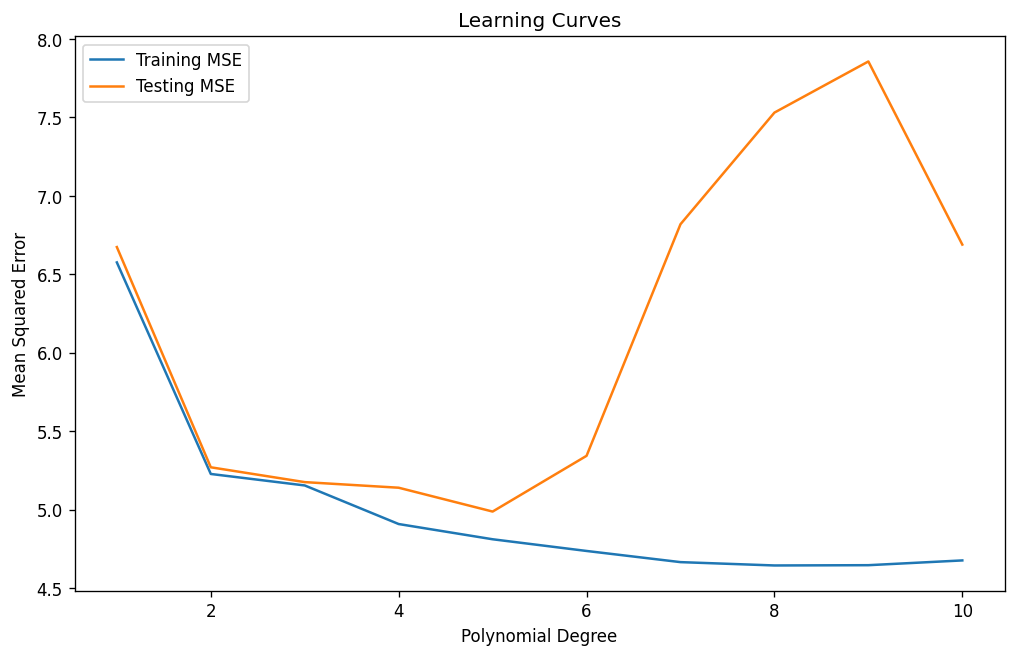

In [64]:
# Initialize lists to store training and testing MSE for different polynomial degrees
train_mse = []
test_mse = []

# Try polynomial degrees from 1 to max_degree
max_degree = 10
for degree in range(1, max_degree+1):
    # Create polynomial features
    poly = PolynomialFeatures(degree=degree)
    X_train_poly = poly.fit_transform(X_train)
    X_test_poly = poly.transform(X_test)
    
    # Train linear regression model
    model = LinearRegression()
    model.fit(X_train_poly, y_train)
    
    # Evaluate model on training and testing sets
    train_mse.append(mean_squared_error(y_train, model.predict(X_train_poly)))
    test_mse.append(mean_squared_error(y_test, model.predict(X_test_poly)))

# Plot learning curves
plt.figure(figsize=(10, 6))
plt.plot(range(1, max_degree+1), train_mse, label='Training MSE')
plt.plot(range(1, max_degree+1), test_mse, label='Testing MSE')
plt.xlabel('Polynomial Degree')
plt.ylabel('Mean Squared Error')
plt.title('Learning Curves')
plt.legend()
plt.show()


##### El grado de polinomio 3 parece tener el menor MSE sin que se separen las curvas de Train y Test

In [73]:
#Entreno el modelo con un polinomio 
poly = PolynomialFeatures(degree=3)
X_train_poly = poly.fit_transform(X_train)
X_test_poly = poly.transform(X_test)
lr_poly = LinearRegression()
lr_poly.fit(X_train_poly, y_train)

LinearRegression()

In [75]:
#Prediccion de la velocidad para todo el dataset
poly = PolynomialFeatures(degree=3)
X_poly = poly.fit_transform(df_clean_ba[['wspd_ms','wdir','temp','pres']])
df_clean_ba['Vel_Viento_pred']= lr_poly.predict(X_poly)

In [76]:
# Set Vel_Viento_pred to 0 if its predicted value is less than 0
df_clean_ba['Vel_Viento_pred'] = np.where(df_clean_ba['Vel_Viento_pred'] < 0, 0, df_clean_ba['Vel_Viento_pred'])

<Axes: >

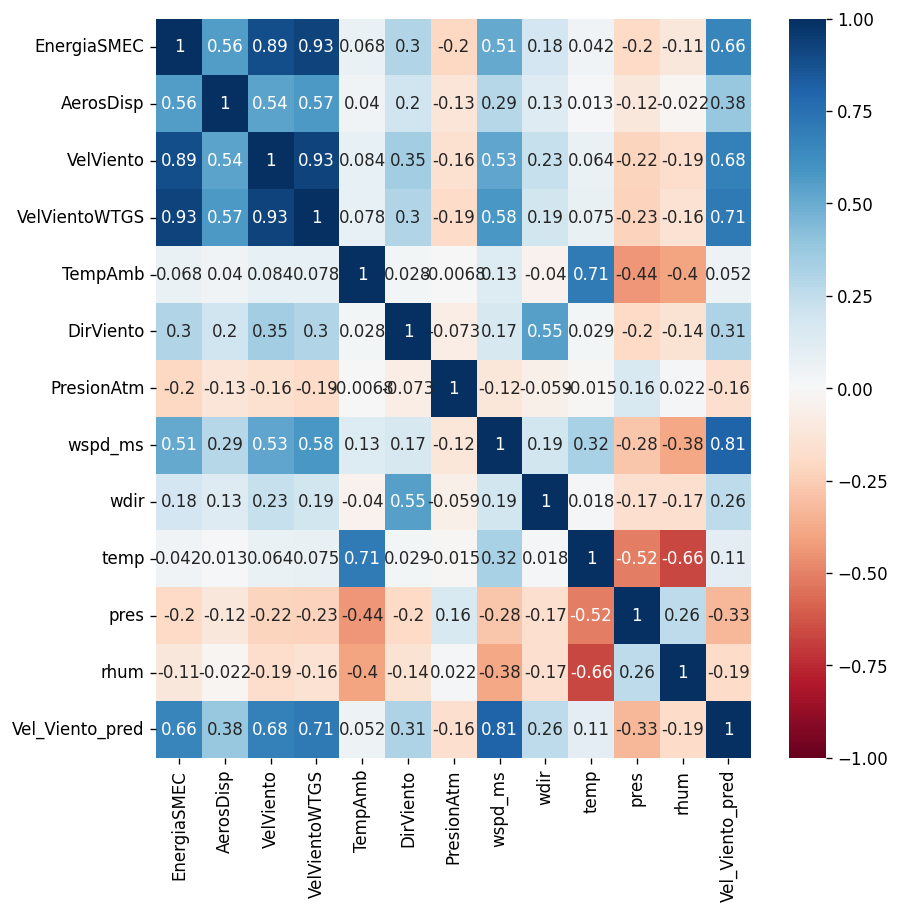

In [77]:
#Matriz de Correlacion
key_vars = ['EnergiaSMEC','AerosDisp','VelViento','VelVientoWTGS','TempAmb','DirViento','PresionAtm','wspd_ms','wdir','temp','pres','rhum','Vel_Viento_pred']

plt.figure(figsize=(8,8))
sns.heatmap(df_clean_ba[key_vars].corr(),annot=True,cmap='RdBu',vmin=-1)

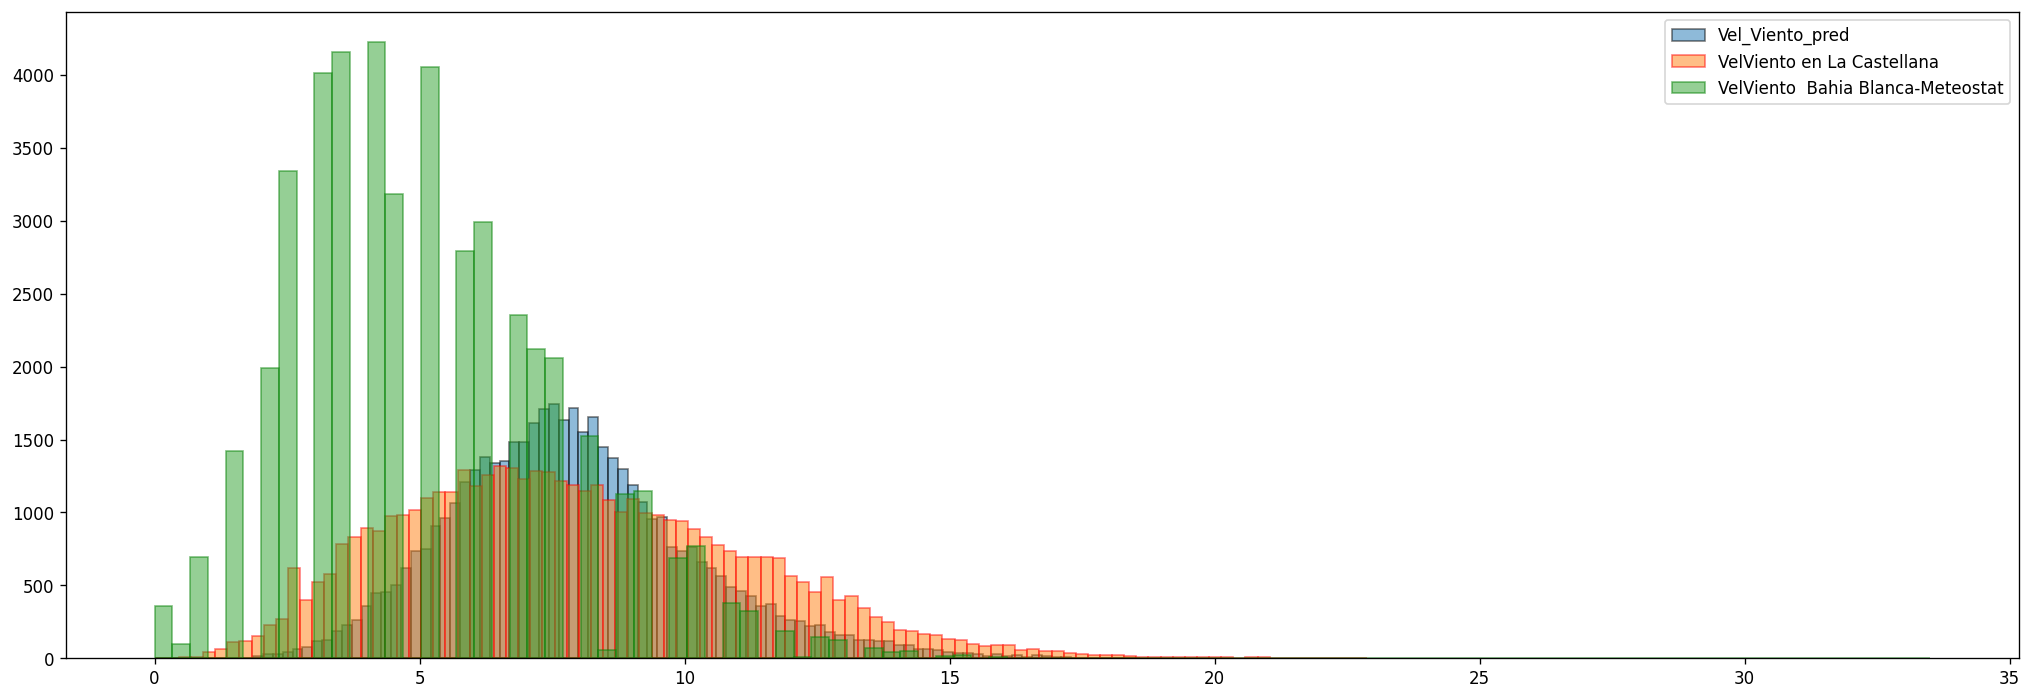

In [78]:
plt.hist(df_clean_ba['Vel_Viento_pred'], edgecolor='black', alpha=0.5, label='Vel_Viento_pred', bins=100)  # Solid line for Variable 1
plt.hist(df_clean_ba['VelVientoWTGS'], edgecolor='red', alpha=0.5, label='VelViento en La Castellana', bins=100)  # Solid line for Variable 2
plt.hist(df_clean_ba['wspd_ms'], edgecolor='green', alpha=0.5, label='VelViento  Bahia Blanca-Meteostat', bins=100)  # Solid line for Variable 2
plt.legend()
plt.show()

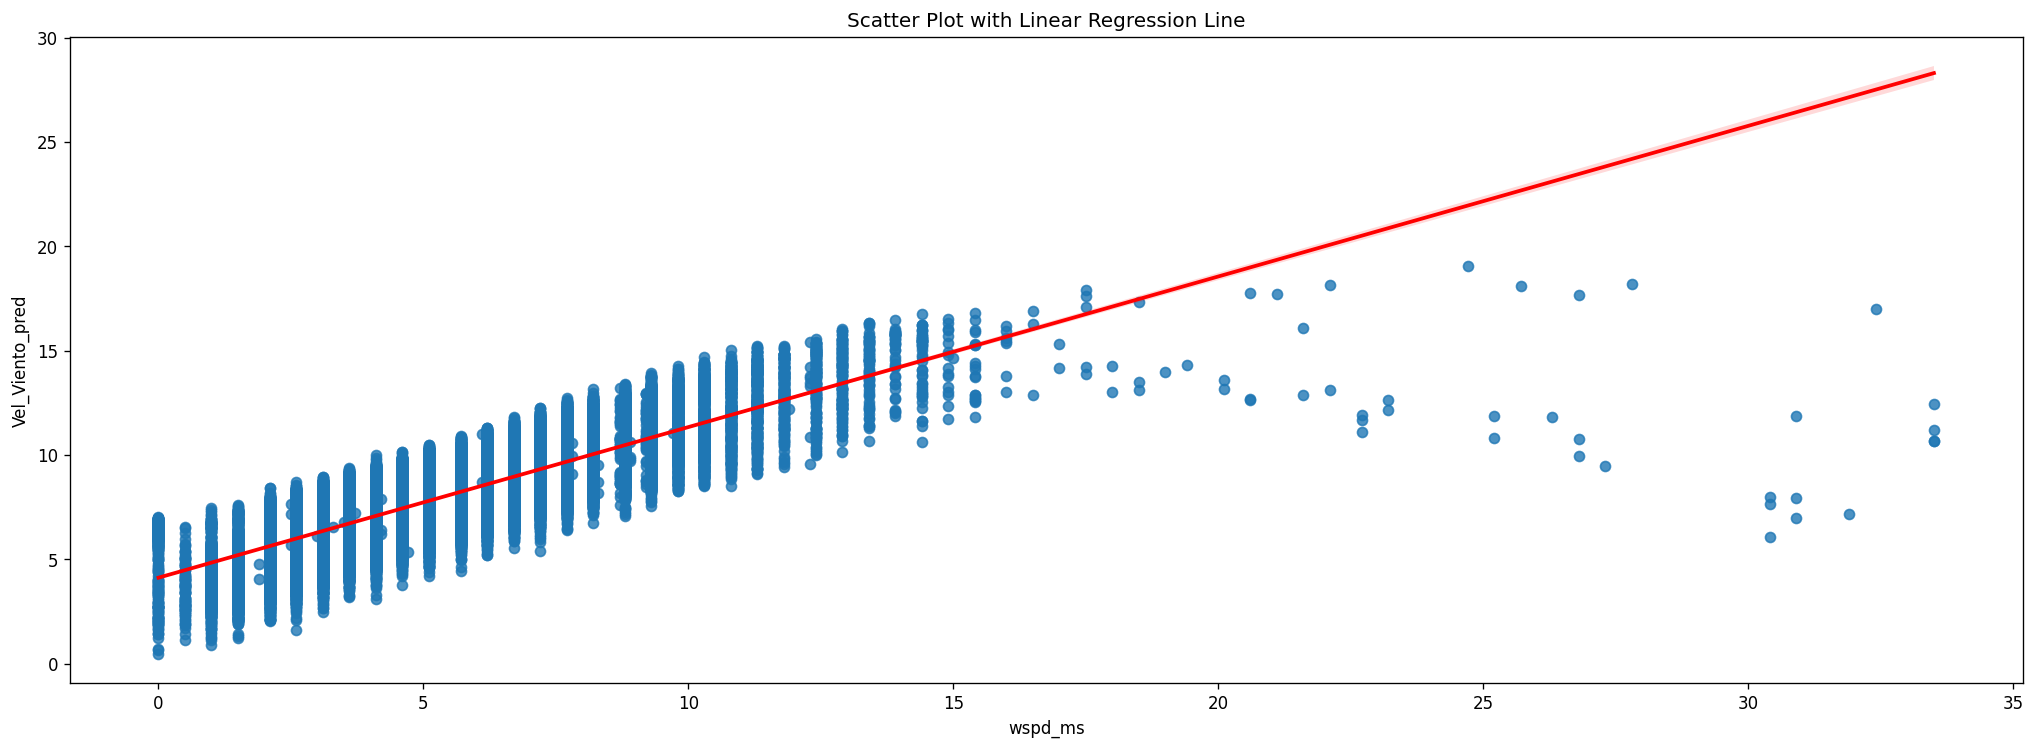

In [70]:
# Scatter plot
sns.regplot(x='wspd_ms', y='Vel_Viento_pred', data=df_clean_ba, line_kws={'color': 'red'})
plt.xlabel('wspd_ms')
plt.ylabel('Vel_Viento_pred')
plt.title('Scatter Plot with Linear Regression Line')
plt.show()

In [71]:
#Exporto el archivo del dataset limpio
df_clean_ba=df_clean_ba.round(2)
df_clean_ba.to_csv('D:\\Documents\\MMA\\1.0 Tesis\\Datos\\df_clean_ba1404.csv', sep=';', index=False, decimal=',')